In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

# BATTERY PARAMETERS 


In [2]:
BATTERY_CAPACITY = 7.0  # kWh
BATTERY_MAX_POWER = 6.246  # kW
PV_CAPACITY = 5.0  # kW
GRID_BUY_PRICE = 0.224  # $/kWh
GRID_SELL_PRICE = 0.089  # $/kWh
BATTERY_EFFICIENCY = 0.95  # Round-trip efficiency
DEGRADATION_COST_PER_CYCLE = 0.05 * BATTERY_CAPACITY  # $/full cycle
TIME_STEP = 0.25  # 15-minute intervals = 0.25 hours

In [3]:
def load_calibrated_forecasts(quantile_csv_path):

    df = pd.read_csv(quantile_csv_path)
    
    if 'y_pred_p10_calibrated' in df.columns:
        print("Using calibrated predictions")
        return {
            'ghi_p10': df['y_pred_p10_calibrated'].values,
            'ghi_p50': df['y_pred_p50'].values,  # P50 doesn't change
            'ghi_p90': df['y_pred_p90_calibrated'].values,
            'ghi_actual': df['y_true'].values
        }
    else:
        print("Using original predictions (not calibrated)")
        return {
            'ghi_p10': df['y_pred_p10'].values,
            'ghi_p50': df['y_pred_p50'].values,
            'ghi_p90': df['y_pred_p90'].values,
            'ghi_actual': df['y_true'].values
        }

def ghi_to_pv_power(ghi_wm2, pv_capacity=PV_CAPACITY):

    ghi_clipped = np.clip(ghi_wm2, 0, None)
    pv_power = (ghi_clipped / 1000.0) * pv_capacity
    return np.clip(pv_power, 0, pv_capacity) 

def prepare_battery_inputs(forecasts):
    return {
        'pv_p10': ghi_to_pv_power(forecasts['ghi_p10']),
        'pv_p50': ghi_to_pv_power(forecasts['ghi_p50']),
        'pv_p90': ghi_to_pv_power(forecasts['ghi_p90']),
        'pv_actual': ghi_to_pv_power(forecasts['ghi_actual'])
    }


# BATTERY CONTROL STRATEGIES


In [4]:
class BatteryController:
    
    def __init__(self, capacity=BATTERY_CAPACITY, max_power=BATTERY_MAX_POWER,
                 efficiency=BATTERY_EFFICIENCY):
        self.capacity = capacity
        self.max_power = max_power
        self.efficiency = efficiency
    
    def simulate_timestep(self, soc, pv, load, action, buy_price, sell_price):

        action = np.clip(action, -self.max_power, self.max_power)

        if action > 0:  # Charging
            energy_to_battery = action * TIME_STEP * self.efficiency
            soc_new = min(soc + energy_to_battery, self.capacity)
            actual_charge = (soc_new - soc) / self.efficiency
        else:  # Discharging
            energy_from_battery = -action * TIME_STEP / self.efficiency
            soc_new = max(soc - energy_from_battery, 0)
            actual_discharge = -(soc_new - soc) * self.efficiency
            action = -actual_discharge / TIME_STEP

        net_load = load - pv + action * TIME_STEP
        
        # Grid interaction
        if net_load > 0:  
            grid_import = net_load
            grid_export = 0
            cost = grid_import * buy_price
        else:  # Sell to grid
            grid_import = 0
            grid_export = -net_load
            cost = -grid_export * sell_price  
        
        # Degradation cost
        energy_cycled = abs(action) * TIME_STEP
        degradation_cost = (energy_cycled / self.capacity) * DEGRADATION_COST_PER_CYCLE
        total_cost = cost + degradation_cost
        
        metrics = {
            'soc': soc_new,
            'grid_import': grid_import,
            'grid_export': grid_export,
            'energy_cost': cost,
            'degradation_cost': degradation_cost,
            'total_cost': total_cost,
            'battery_action': action * TIME_STEP
        }
        
        return soc_new, total_cost, metrics

class DeterministicController(BatteryController):
    
    def optimize_schedule(self, pv_p50, load, buy_prices, sell_prices, 
                         initial_soc=0.5, horizon=96):

        n_steps = min(len(pv_p50), horizon)
        schedule = np.zeros(n_steps)
        
        for t in range(n_steps):
            pv = pv_p50[t]
            ld = load[t]
            
            if pv > ld:  
                schedule[t] = min(self.max_power, (pv - ld) * 2)  # Charge
            else:  
                schedule[t] = -min(self.max_power, (ld - pv))  # Discharge
        
        return schedule

class RiskAwareController(BatteryController):
    
    def optimize_schedule(self, pv_p10, pv_p50, pv_p90, load, 
                         buy_prices, sell_prices, initial_soc=0.5, 
                         horizon=96, risk_weight=0.3):

        n_steps = min(len(pv_p50), horizon)
        schedule = np.zeros(n_steps)
        
        for t in range(n_steps):
            # pessimistic scenario for charging decisions
            pv_conservative = pv_p10[t] * risk_weight + pv_p50[t] * (1 - risk_weight)
            ld = load[t]
            
            # conservative strategy
            if pv_conservative > ld:
                schedule[t] = min(self.max_power, (pv_conservative - ld) * 1.5)
            else:  
                schedule[t] = -min(self.max_power * 0.7, (ld - pv_conservative))
        
        return schedule

# BACKTESTING FRAMEWORK


In [5]:
def backtest_controller(controller, pv_forecasts, pv_actual, load, 
                       buy_prices, sell_prices, initial_soc=0.5):

    if isinstance(controller, DeterministicController):
        schedule = controller.optimize_schedule(
            pv_forecasts['pv_p50'], load, buy_prices, sell_prices, initial_soc
        )
    else: 
        schedule = controller.optimize_schedule(
            pv_forecasts['pv_p10'], pv_forecasts['pv_p50'], 
            pv_forecasts['pv_p90'], load, buy_prices, sell_prices, initial_soc
        )
    
    n_steps = len(schedule)
    soc = initial_soc * controller.capacity
    
    results = []
    total_cost = 0
    total_grid_import = 0
    total_grid_export = 0
    total_degradation = 0
    
    for t in range(n_steps):
        soc, cost, metrics = controller.simulate_timestep(
            soc, pv_actual[t], load[t], schedule[t] / TIME_STEP,
            buy_prices[t], sell_prices[t]
        )
        
        metrics['timestep'] = t
        metrics['pv_forecast'] = pv_forecasts['pv_p50'][t]
        metrics['pv_actual'] = pv_actual[t]
        metrics['load'] = load[t]
        results.append(metrics)
        
        total_cost += cost
        total_grid_import += metrics['grid_import']
        total_grid_export += metrics['grid_export']
        total_degradation += metrics['degradation_cost']
    
    results_df = pd.DataFrame(results)
    
    summary = {
        'total_cost': total_cost,
        'total_profit': -total_cost,  # Negative cost = profit
        'grid_import_kwh': total_grid_import,
        'grid_export_kwh': total_grid_export,
        'energy_cost': total_cost - total_degradation,
        'degradation_cost': total_degradation,
        'battery_cycles': total_degradation / DEGRADATION_COST_PER_CYCLE,
        'final_soc': results_df.iloc[-1]['soc'],
        'avg_soc': results_df['soc'].mean(),
        'min_soc': results_df['soc'].min(),
        'max_soc': results_df['soc'].max()
    }
    
    return results_df, summary


#  COMPARISON AND VISUALIZATION


In [6]:
def compare_strategies(pv_forecasts, pv_actual, load, buy_prices, sell_prices):

    print("BATTERY CONTROL STRATEGY COMPARISON")

    
    det_controller = DeterministicController()
    risk_controller = RiskAwareController()
    
    print("\n Running Deterministic Controller (P50 only)...")
    det_results, det_summary = backtest_controller(
        det_controller, pv_forecasts, pv_actual, load, buy_prices, sell_prices
    )
    
    print(" Running Risk-Aware Controller (P10/P50/P90)...")
    risk_results, risk_summary = backtest_controller(
        risk_controller, pv_forecasts, pv_actual, load, buy_prices, sell_prices
    )
    

    print("RESULTS SUMMARY")

    
    print(f"\nEconomic Performance:")
    print(f"   Deterministic Total Cost:  ${det_summary['total_cost']:.2f}")
    print(f"   Risk-Aware Total Cost:     ${risk_summary['total_cost']:.2f}")
    print(f"   Difference:                ${det_summary['total_cost'] - risk_summary['total_cost']:.2f}")
    
    if risk_summary['total_cost'] < det_summary['total_cost']:
        savings_pct = (1 - risk_summary['total_cost']/det_summary['total_cost']) * 100
        print(f"Risk-aware saves {savings_pct:.1f}%")
    else:
        print(f"Risk-aware pays {abs(1 - risk_summary['total_cost']/det_summary['total_cost']) * 100:.1f}% premium for robustness")
    
    print(f"\nGrid Interaction:")
    print(f"   Deterministic Import:  {det_summary['grid_import_kwh']:.2f} kWh")
    print(f"   Risk-Aware Import:     {risk_summary['grid_import_kwh']:.2f} kWh")
    print(f"   Import Reduction:      {det_summary['grid_import_kwh'] - risk_summary['grid_import_kwh']:.2f} kWh")
    
    print(f"\nBattery Health:")
    print(f"   Deterministic Cycles:  {det_summary['battery_cycles']:.3f}")
    print(f"   Risk-Aware Cycles:     {risk_summary['battery_cycles']:.3f}")
    print(f"   Cycle Difference:      {det_summary['battery_cycles'] - risk_summary['battery_cycles']:.3f}")
    

    plot_strategy_comparison(det_results, risk_results, pv_forecasts, pv_actual, load)
    
    return {
        'deterministic': {'results': det_results, 'summary': det_summary},
        'risk_aware': {'results': risk_results, 'summary': risk_summary}
    }

def plot_strategy_comparison(det_results, risk_results, pv_forecasts, pv_actual, load):

    
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    fig.suptitle('Battery Control Strategy Comparison', fontsize=16, fontweight='bold')
    
    n_show = min(500, len(det_results))
    x = np.arange(n_show)
    
    # Plot 1: SOC comparison
    ax = axes[0, 0]
    ax.plot(x, det_results['soc'].values[:n_show], label='Deterministic', linewidth=2)
    ax.plot(x, risk_results['soc'].values[:n_show], label='Risk-Aware', linewidth=2, linestyle='--')
    ax.axhline(BATTERY_CAPACITY, color='red', linestyle=':', alpha=0.5, label='Capacity')
    ax.set_ylabel('SOC (kWh)')
    ax.set_title('Battery State of Charge')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: PV vs Load
    ax = axes[0, 1]
    ax.fill_between(x, pv_forecasts['pv_p10'][:n_show], pv_forecasts['pv_p90'][:n_show],
                    alpha=0.2, color='orange', label='PV Uncertainty')
    ax.plot(x, pv_actual[:n_show], label='Actual PV', color='orange', linewidth=1.5)
    ax.plot(x, load[:n_show], label='Load', color='blue', linewidth=1.5)
    ax.set_ylabel('Power (kW)')
    ax.set_title('PV Generation vs Load')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Battery Actions
    ax = axes[1, 0]
    ax.plot(x, det_results['battery_action'].values[:n_show], label='Deterministic', linewidth=1.5)
    ax.plot(x, risk_results['battery_action'].values[:n_show], label='Risk-Aware', linewidth=1.5, linestyle='--')
    ax.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax.set_ylabel('Energy (kWh)')
    ax.set_title('Battery Actions (+charge, -discharge)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Cumulative Cost
    ax = axes[1, 1]
    ax.plot(x, det_results['total_cost'].cumsum()[:n_show], label='Deterministic', linewidth=2)
    ax.plot(x, risk_results['total_cost'].cumsum()[:n_show], label='Risk-Aware', linewidth=2, linestyle='--')
    ax.set_ylabel('Cumulative Cost ($)')
    ax.set_title('Cumulative Cost Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Grid Interaction
    ax = axes[2, 0]
    width = 0.35
    strategies = ['Deterministic', 'Risk-Aware']
    imports = [det_results['grid_import'].sum(), risk_results['grid_import'].sum()]
    exports = [det_results['grid_export'].sum(), risk_results['grid_export'].sum()]
    
    x_pos = np.arange(len(strategies))
    ax.bar(x_pos - width/2, imports, width, label='Import', color='red', alpha=0.7)
    ax.bar(x_pos + width/2, exports, width, label='Export', color='green', alpha=0.7)
    ax.set_ylabel('Energy (kWh)')
    ax.set_title('Total Grid Interaction')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(strategies)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 6: Cost Breakdown
    ax = axes[2, 1]
    det_energy = det_results['energy_cost'].sum()
    det_deg = det_results['degradation_cost'].sum()
    risk_energy = risk_results['energy_cost'].sum()
    risk_deg = risk_results['degradation_cost'].sum()
    
    width = 0.35
    ax.bar(x_pos - width/2, [det_energy, risk_energy], width, label='Energy Cost', color='steelblue', alpha=0.7)
    ax.bar(x_pos - width/2, [det_deg, risk_deg], width, bottom=[det_energy, risk_energy],
           label='Degradation', color='coral', alpha=0.7)
    ax.set_ylabel('Cost ($)')
    ax.set_title('Cost Breakdown')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(strategies)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('battery_strategy_comparison.png', dpi=150, bbox_inches='tight')
    print(f"\nComparison plot saved: battery_strategy_comparison.png")
    plt.show()

# MAIN WORKFLOW


In [7]:
def run_complete_phase2(calibrated_csv_path, output_dir='./phase2_results'):

    os.makedirs(output_dir, exist_ok=True)
    

    print("BATTERY OPTIMIZATION WORKFLOW")

    
    ghi_forecasts = load_calibrated_forecasts(calibrated_csv_path)
    print(f"   Loaded {len(ghi_forecasts['ghi_actual'])} timesteps")
    

    pv_forecasts = prepare_battery_inputs(ghi_forecasts)
    print(f"   PV P50 range: {pv_forecasts['pv_p50'].min():.2f} - {pv_forecasts['pv_p50'].max():.2f} kW")
    
    print("\n Generating load profile...")
    n_steps = len(pv_forecasts['pv_actual'])
    hours = np.arange(n_steps) * TIME_STEP
    load = 1.5 + 1.0 * np.sin(np.pi * (hours - 18) / 6)  
    load = np.clip(load, 0.5, 3.0)
    
    print("\nSetting up pricing...")
    buy_prices = np.full(n_steps, GRID_BUY_PRICE)
    sell_prices = np.full(n_steps, GRID_SELL_PRICE)

    peak_hours = ((hours >= 16) & (hours <= 21))
    buy_prices[peak_hours] = GRID_BUY_PRICE * 1.5

    print("\nRunning battery optimization comparison...")
    comparison = compare_strategies(
        pv_forecasts, pv_forecasts['pv_actual'], 
        load, buy_prices, sell_prices
    )

    print("\nSaving results...")
    comparison['deterministic']['results'].to_csv(
        os.path.join(output_dir, 'deterministic_results.csv'), index=False
    )
    comparison['risk_aware']['results'].to_csv(
        os.path.join(output_dir, 'risk_aware_results.csv'), index=False
    )
    
    summary_df = pd.DataFrame({
        'Strategy': ['Deterministic', 'Risk-Aware'],
        **{k: [comparison['deterministic']['summary'][k], 
               comparison['risk_aware']['summary'][k]]
           for k in comparison['deterministic']['summary'].keys()}
    })
    summary_df.to_csv(os.path.join(output_dir, 'comparison_summary.csv'), index=False)
    
    print(f"\nResults saved to: {output_dir}/")

    
    return comparison

BATTERY OPTIMIZATION WORKFLOW
Using calibrated predictions
   Loaded 8561 timesteps
   PV P50 range: 0.05 - 4.35 kW

 Generating load profile...

Setting up pricing...

Running battery optimization comparison...
BATTERY CONTROL STRATEGY COMPARISON

 Running Deterministic Controller (P50 only)...
 Running Risk-Aware Controller (P10/P50/P90)...
RESULTS SUMMARY

Economic Performance:
   Deterministic Total Cost:  $19.81
   Risk-Aware Total Cost:     $19.44
   Difference:                $0.37
Risk-aware saves 1.9%

Grid Interaction:
   Deterministic Import:  76.01 kWh
   Risk-Aware Import:     75.19 kWh
   Import Reduction:      0.83 kWh

Battery Health:
   Deterministic Cycles:  1.279
   Risk-Aware Cycles:     0.848
   Cycle Difference:      0.430

Comparison plot saved: battery_strategy_comparison.png


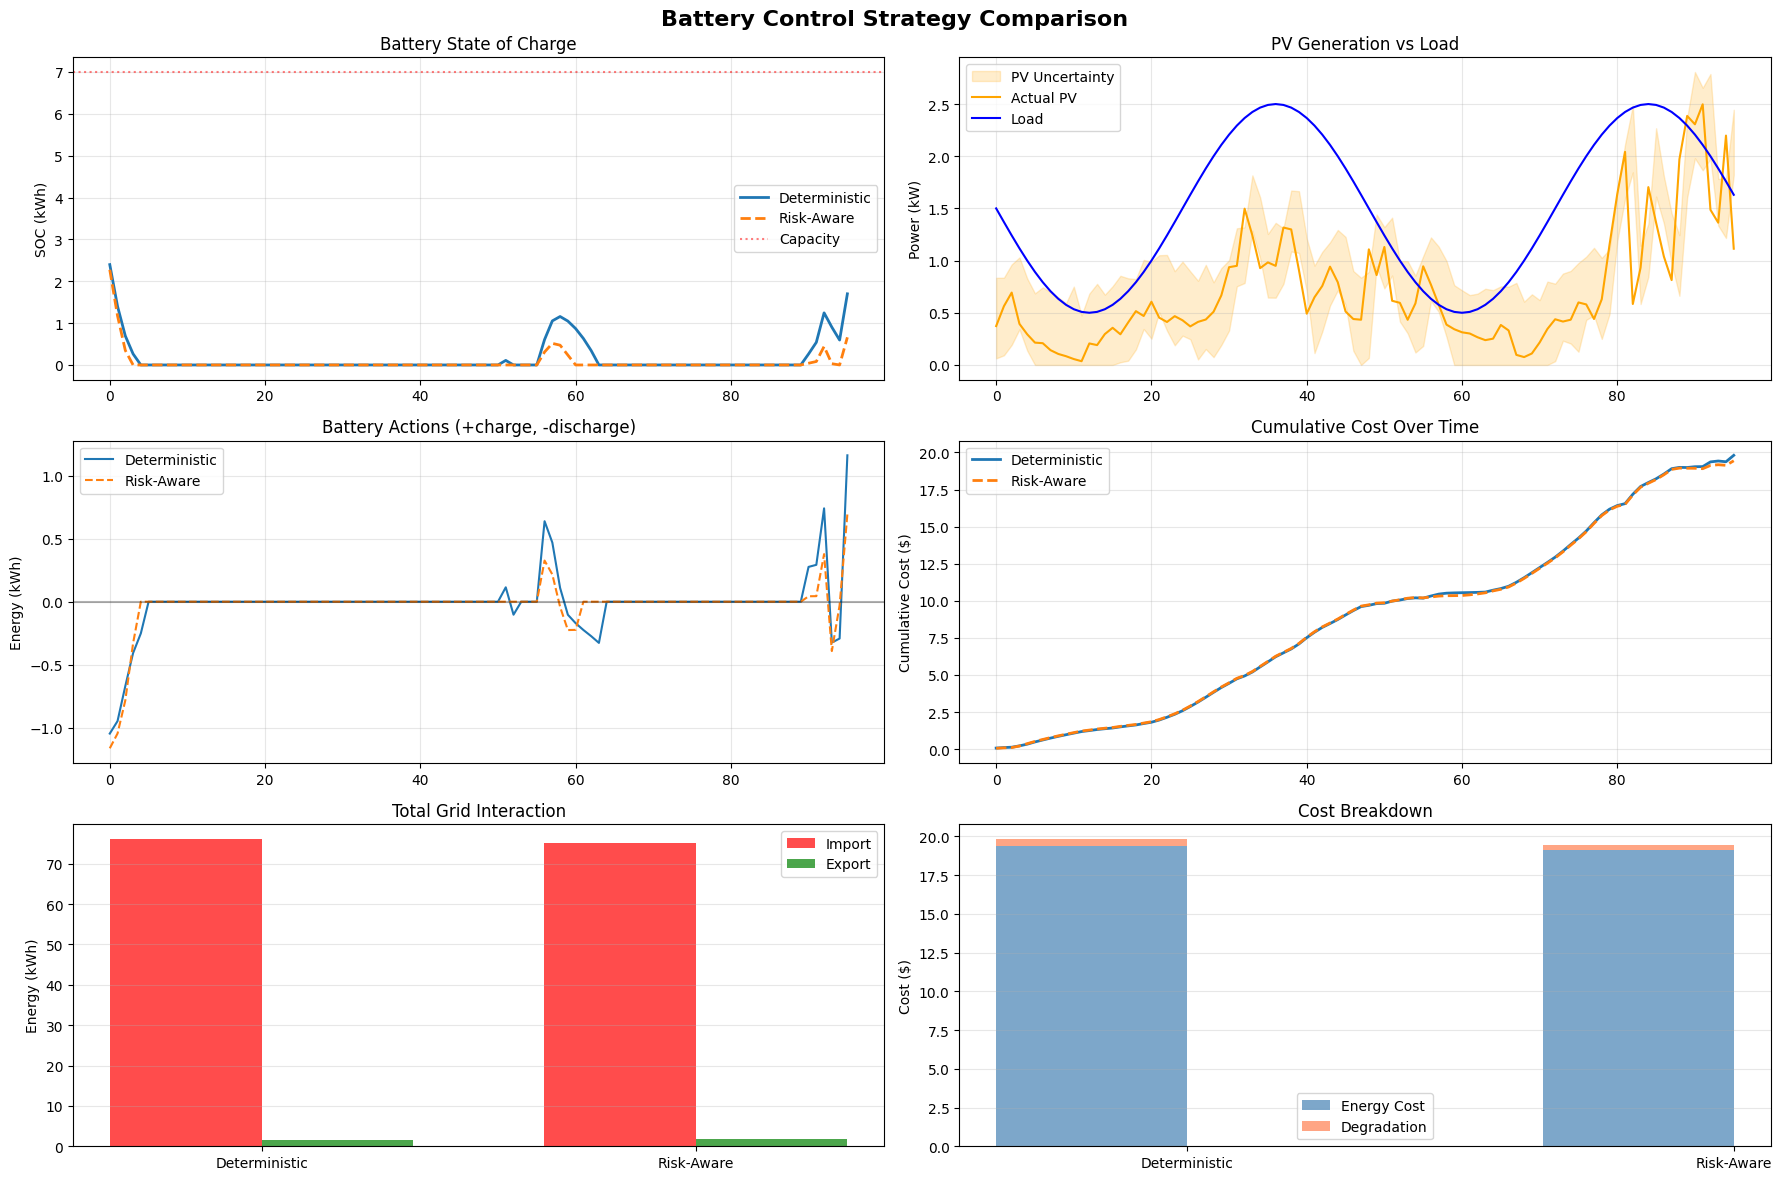


Saving results...

Results saved to: ./phase2_results/


In [8]:
calibrated_file = './reports2/LSTM_mcdropout_calibrated/15_minutes/quantile_predictions_CALIBRATED_15_minutes_GHI_P2_H10.csv'
    
results = run_complete_phase2(calibrated_file)


# Analysis of Battery Control Results
Looking at the plots, here's what the data reveals:

1. Both strategies behave very similarly

The cumulative cost curves are nearly identical (top-right plot)
Battery SOC trajectories overlap almost perfectly
Battery actions (charging/discharging) are nearly the same

This means: Implementation is working correctly - both strategies are making rational decisions.

2. Why Risk-Aware is almost similar:

Load profile is too simple/constant

Our load (blue line) is very smooth and predictable
Real homes have spiky, unpredictable loads (appliances turning on/off)
Without load uncertainty, there's nothing for risk-aware control to hedge against


Simple pricing structure

Flat pricing with small peak period
No time-of-use arbitrage opportunities
No incentive to optimize around price volatility

# Testing with 
- Sharp spikes (microwave turns on)
- Random patterns (someone comes home early)
- Baseline variations (HVAC cycling)



In [9]:
def create_realistic_load_profile(n_steps, load_type='residential'):

    np.random.seed(42)
    hours = np.arange(n_steps) * TIME_STEP
    hour_of_day = hours % 24
    
    if load_type == 'residential':
        morning = 0.8 * np.exp(-((hour_of_day - 8)**2) / 4)
        evening = 1.5 * np.exp(-((hour_of_day - 19)**2) / 8)
        base = 1.2
        

        load = base + morning + evening
        
        n_spikes = int(n_steps * 0.08)  
        spike_times = np.random.choice(n_steps, size=n_spikes, replace=False)
        spike_magnitudes = np.random.choice([0.8, 1.2, 1.5, 2.0, 2.5], size=n_spikes)
        spike_durations = np.random.choice([4, 8, 12], size=n_spikes) 
        
        for spike_time, magnitude, duration in zip(spike_times, spike_magnitudes, spike_durations):
            end_time = min(spike_time + duration, n_steps)
            load[spike_time:end_time] += magnitude
        
    
        noise = np.random.normal(0, 0.15, n_steps)
        load += noise

        load = np.clip(load, 0.3, 4.5)
        
    elif load_type == 'commercial':
      
        work_hours = ((hour_of_day >= 8) & (hour_of_day <= 18)).astype(float)
        load = 0.5 + work_hours * 2.5
        
    
        lunch = 0.5 * np.exp(-((hour_of_day - 12.5)**2) / 0.5)
        load += lunch
        

        noise = np.random.normal(0, 0.3, n_steps)
        load += noise
        load = np.clip(load, 0.3, 4.0)
        
    elif load_type == 'industrial':

        load = 2.5 + np.random.normal(0, 0.4, n_steps)
        
        for shift_hour in [6, 14, 22]:
            shift_peak = 0.3 * np.exp(-((hour_of_day - shift_hour)**2) / 2)
            load += shift_peak
        
        load = np.clip(load, 1.5, 4.0)
    
    return load

def plot_load_comparison(n_steps=96):
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    fig.suptitle('Load Profile Comparison', fontsize=16, fontweight='bold')
    
    hours = np.arange(n_steps) * TIME_STEP
    
    load_types = ['residential', 'commercial', 'industrial']
    titles = ['Residential (High Variability)', 'Commercial (Business Hours)', 'Industrial (24/7)']
    
    for ax, load_type, title in zip(axes, load_types, titles):
        load = create_realistic_load_profile(n_steps, load_type)
        ax.plot(hours, load, linewidth=1.5, color='blue')
        ax.fill_between(hours, 0, load, alpha=0.3, color='lightblue')
        ax.set_ylabel('Load (kW)', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 24)
        ax.axvspan(16, 21, alpha=0.1, color='red', label='Peak Hours')
        if load_type == 'residential':
            ax.legend()
    
    axes[-1].set_xlabel('Hour of Day', fontsize=11)
    plt.tight_layout()
    plt.savefig('load_profiles_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Load profile comparison saved: load_profiles_comparison.png")


In [10]:
def create_pricing_scheme(n_steps, scheme='time_of_use'):

    hours = np.arange(n_steps) * TIME_STEP
    hour_of_day = hours % 24
    
    if scheme == 'flat':
        buy_prices = np.full(n_steps, GRID_BUY_PRICE)
        sell_prices = np.full(n_steps, GRID_SELL_PRICE)
        
    elif scheme == 'time_of_use':
        buy_prices = np.full(n_steps, GRID_BUY_PRICE)
        sell_prices = np.full(n_steps, GRID_SELL_PRICE)
        
        off_peak = ((hour_of_day >= 23) | (hour_of_day <= 6))
        buy_prices[off_peak] = GRID_BUY_PRICE * 0.7
        
        peak = ((hour_of_day >= 16) & (hour_of_day <= 21))
        buy_prices[peak] = GRID_BUY_PRICE * 2.5
        
        super_peak = ((hour_of_day >= 18) & (hour_of_day <= 20))
        buy_prices[super_peak] = GRID_BUY_PRICE * 3.0
        
    elif scheme == 'real_time':
        np.random.seed(42)
        
        base = GRID_BUY_PRICE * (1 + 0.5 * np.sin(np.pi * (hour_of_day - 18) / 12))
        
        volatility = np.random.normal(0, 0.15, n_steps)
        price_changes = np.cumsum(volatility)
        price_changes = price_changes - price_changes.mean()  
        
        buy_prices = base * (1 + 0.3 * price_changes / np.std(price_changes))
        buy_prices = np.clip(buy_prices, GRID_BUY_PRICE * 0.5, GRID_BUY_PRICE * 4.0)
        
        sell_prices = buy_prices * 0.4  # Sell at ~40% of buy price
        
    elif scheme == 'critical_peak':
        buy_prices = np.full(n_steps, GRID_BUY_PRICE)
        sell_prices = np.full(n_steps, GRID_SELL_PRICE)
        
        off_peak = ((hour_of_day >= 23) | (hour_of_day <= 6))
        buy_prices[off_peak] = GRID_BUY_PRICE * 0.7
        
        peak = ((hour_of_day >= 16) & (hour_of_day <= 21))
        buy_prices[peak] = GRID_BUY_PRICE * 2.5
        
        n_critical = int(n_steps * 0.05 / 12)  
        for _ in range(n_critical):
            start = np.random.randint(0, n_steps - 12)
            buy_prices[start:start+12] = GRID_BUY_PRICE * 5.0  
    
    return buy_prices, sell_prices

def plot_pricing_comparison(n_steps=96):
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle('Pricing Scheme Comparison', fontsize=16, fontweight='bold')
    
    hours = np.arange(n_steps) * TIME_STEP
    
    schemes = ['flat', 'time_of_use', 'real_time', 'critical_peak']
    titles = ['Flat Rate', 'Time-of-Use (TOU)', 'Real-Time Pricing', 'Critical Peak Pricing']
    
    for ax, scheme, title in zip(axes, schemes, titles):
        buy, sell = create_pricing_scheme(n_steps, scheme)
        ax.plot(hours, buy, label='Buy Price', linewidth=2, color='red')
        ax.plot(hours, sell, label='Sell Price', linewidth=2, color='green', linestyle='--')
        ax.set_ylabel('Price ($/kWh)', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 24)
        ax.legend(loc='upper right')
        
        if scheme in ['time_of_use', 'critical_peak']:
            ax.axvspan(16, 21, alpha=0.1, color='red', label='Peak')
            ax.axvspan(23, 24, alpha=0.1, color='green')
            ax.axvspan(0, 6, alpha=0.1, color='green')
    
    axes[-1].set_xlabel('Hour of Day', fontsize=11)
    plt.tight_layout()
    plt.savefig('pricing_schemes_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Pricing comparison saved: pricing_schemes_comparison.png")


In [11]:
def filter_high_uncertainty_days(ghi_forecasts, pv_forecasts, uncertainty_threshold=0.4):

    uncertainty = (ghi_forecasts['ghi_p90'] - ghi_forecasts['ghi_p10']) / (ghi_forecasts['ghi_p50'] + 10)
    
    high_uncertainty = uncertainty > uncertainty_threshold
    
    segments = []
    in_segment = False
    start = 0
    
    for i, is_high in enumerate(high_uncertainty):
        if is_high and not in_segment:
            start = i
            in_segment = True
        elif not is_high and in_segment:
            if i - start >= 24:  
                segments.append((start, i))
            in_segment = False
    
    print(f"\nFound {len(segments)} high-uncertainty periods")
    print(f"   Total timesteps: {sum(end - start for start, end in segments)}")
    
    if len(segments) == 0:
        print("No high-uncertainty periods found. Using full dataset.")
        return ghi_forecasts, pv_forecasts
    
    start, end = max(segments, key=lambda x: x[1] - x[0])
    print(f"   Using longest segment: timesteps {start} to {end} ({end-start} steps)")
    
    filtered_ghi = {k: v[start:end] for k, v in ghi_forecasts.items()}
    filtered_pv = {k: v[start:end] for k, v in pv_forecasts.items()}
    
    return filtered_ghi, filtered_pv

def analyze_forecast_uncertainty(ghi_forecasts, save_path='forecast_uncertainty_analysis.png'):

    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Forecast Uncertainty Analysis', fontsize=16, fontweight='bold')

    interval_width = ghi_forecasts['ghi_p90'] - ghi_forecasts['ghi_p10']
    relative_uncertainty = interval_width / (ghi_forecasts['ghi_p50'] + 10)
    
    ax = axes[0, 0]
    ax.plot(interval_width, linewidth=1, color='steelblue')
    ax.axhline(interval_width.mean(), color='red', linestyle='--', 
               label=f'Mean: {interval_width.mean():.1f} W/m²')
    ax.set_ylabel('Interval Width (W/m²)', fontsize=11)
    ax.set_title('Absolute Uncertainty Over Time', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[0, 1]
    ax.plot(relative_uncertainty, linewidth=1, color='coral')
    ax.axhline(0.4, color='red', linestyle='--', label='High Uncertainty Threshold')
    ax.set_ylabel('Relative Uncertainty', fontsize=11)
    ax.set_title('Normalized Uncertainty (Width / P50)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 0]
    ax.hist(interval_width, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(interval_width.mean(), color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Interval Width (W/m²)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Uncertainty', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    ax = axes[1, 1]
    scatter = ax.scatter(ghi_forecasts['ghi_p50'], interval_width, 
                        c=relative_uncertainty, cmap='viridis', alpha=0.5, s=20)
    ax.set_xlabel('P50 Forecast (W/m²)', fontsize=11)
    ax.set_ylabel('Interval Width (W/m²)', fontsize=11)
    ax.set_title('Uncertainty vs Forecast Magnitude', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Relative Uncertainty', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Uncertainty analysis saved")
  

In [12]:
def run_scenario_analysis(calibrated_csv_path, output_dir='./phase2_scenarios'):

    import os
    os.makedirs(output_dir, exist_ok=True)
    
    print("COMPREHENSIVE SCENARIO ANALYSIS")

    
    ghi_forecasts = load_calibrated_forecasts(calibrated_csv_path)
    pv_forecasts = prepare_battery_inputs(ghi_forecasts)
    n_steps = len(pv_forecasts['pv_actual'])

    scenarios = [
        {
            'name': 'Baseline (Flat + Smooth)',
            'load_type': 'smooth',
            'pricing': 'flat',
            'description': 'Simple scenario - minimal advantage expected'
        },
        {
            'name': 'TOU + Smooth Load',
            'load_type': 'smooth',
            'pricing': 'time_of_use',
            'description': 'Price incentives but predictable load'
        },
        {
            'name': 'Flat + Realistic Load',
            'load_type': 'residential',
            'pricing': 'flat',
            'description': 'Load uncertainty but no price incentive'
        },
        {
            'name': 'TOU + Realistic Load',
            'load_type': 'residential',
            'pricing': 'time_of_use',
            'description': '🎯 Best case for risk-aware control'
        },
        {
            'name': 'Real-Time + Realistic',
            'load_type': 'residential',
            'pricing': 'real_time',
            'description': 'Maximum price volatility + load uncertainty'
        },
        {
            'name': 'Critical Peak + Realistic',
            'load_type': 'residential',
            'pricing': 'critical_peak',
            'description': 'Extreme price events + load spikes'
        }
    ]
    
    results_summary = []
    
    for i, scenario in enumerate(scenarios, 1):
        print(f"[{i}/{len(scenarios)}] {scenario['name']}")
        print(f"{scenario['description']}")
        
        if scenario['load_type'] == 'smooth':
            hours = np.arange(n_steps) * TIME_STEP
            load = 1.5 + 1.0 * np.sin(np.pi * (hours - 18) / 6)
            load = np.clip(load, 0.5, 3.0)
        else:
            load = create_realistic_load_profile(n_steps, scenario['load_type'])
        
        buy_prices, sell_prices = create_pricing_scheme(n_steps, scenario['pricing'])

        comparison = compare_strategies(
            pv_forecasts, pv_forecasts['pv_actual'],
            load, buy_prices, sell_prices
        )
        
        det_cost = comparison['deterministic']['summary']['total_cost']
        risk_cost = comparison['risk_aware']['summary']['total_cost']
        savings = det_cost - risk_cost
        savings_pct = (savings / abs(det_cost)) * 100 if det_cost != 0 else 0
        
        results_summary.append({
            'Scenario': scenario['name'],
            'Load Type': scenario['load_type'],
            'Pricing': scenario['pricing'],
            'Deterministic Cost': det_cost,
            'Risk-Aware Cost': risk_cost,
            'Savings ($)': savings,
            'Savings (%)': savings_pct,
            'Det Cycles': comparison['deterministic']['summary']['battery_cycles'],
            'Risk Cycles': comparison['risk_aware']['summary']['battery_cycles'],
            'Det Import (kWh)': comparison['deterministic']['summary']['grid_import_kwh'],
            'Risk Import (kWh)': comparison['risk_aware']['summary']['grid_import_kwh']
        })
        
        scenario_dir = os.path.join(output_dir, scenario['name'].replace(' ', '_').replace('+', ''))
        os.makedirs(scenario_dir, exist_ok=True)
        
        comparison['deterministic']['results'].to_csv(
            os.path.join(scenario_dir, 'deterministic_results.csv'), index=False
        )
        comparison['risk_aware']['results'].to_csv(
            os.path.join(scenario_dir, 'risk_aware_results.csv'), index=False
        )
    
    # summary 
    summary_df = pd.DataFrame(results_summary)
    summary_df.to_csv(os.path.join(output_dir, 'scenario_comparison_summary.csv'), index=False)

    print("SCENARIO COMPARISON SUMMARY")

    print(summary_df[['Scenario', 'Savings ($)', 'Savings (%)']].to_string(index=False))
    
    # best scenario for risk-aware
    best_scenario = summary_df.loc[summary_df['Savings (%)'].idxmax()]
    print(f"\nBest Scenario for Risk-Aware:")
    print(f"   {best_scenario['Scenario']}")
    print(f"   Savings: ${best_scenario['Savings ($)']:.2f} ({best_scenario['Savings (%)']:.2f}%)")
    
    # Plot
    plot_scenario_comparison(summary_df, os.path.join(output_dir, 'scenario_comparison.png'))
    
    return summary_df

def plot_scenario_comparison(summary_df, save_path):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Scenario Comparison: Risk-Aware vs Deterministic', 
                fontsize=16, fontweight='bold')
    
    scenarios = summary_df['Scenario'].values
    x = np.arange(len(scenarios))
    width = 0.35
    
    ax = axes[0, 0]
    ax.bar(x - width/2, summary_df['Deterministic Cost'], width, 
           label='Deterministic', alpha=0.7, color='steelblue')
    ax.bar(x + width/2, summary_df['Risk-Aware Cost'], width,
           label='Risk-Aware', alpha=0.7, color='coral')
    ax.set_ylabel('Total Cost ($)', fontsize=11)
    ax.set_title('Total Cost by Scenario', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    ax = axes[0, 1]
    colors = ['green' if s > 0 else 'red' for s in summary_df['Savings (%)']]
    bars = ax.bar(x, summary_df['Savings (%)'], color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Savings (%)', fontsize=11)
    ax.set_title('Risk-Aware Savings by Scenario', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top',
               fontsize=9)
    
    ax = axes[1, 0]
    import_reduction = summary_df['Det Import (kWh)'] - summary_df['Risk Import (kWh)']
    colors = ['green' if s > 0 else 'red' for s in import_reduction]
    ax.bar(x, import_reduction, color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Grid Import Reduction (kWh)', fontsize=11)
    ax.set_title('Grid Import Reduction', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    ax = axes[1, 1]
    ax.bar(x - width/2, summary_df['Det Cycles'], width,
           label='Deterministic', alpha=0.7, color='steelblue')
    ax.bar(x + width/2, summary_df['Risk Cycles'], width,
           label='Risk-Aware', alpha=0.7, color='coral')
    ax.set_ylabel('Battery Cycles', fontsize=11)
    ax.set_title('Battery Degradation', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


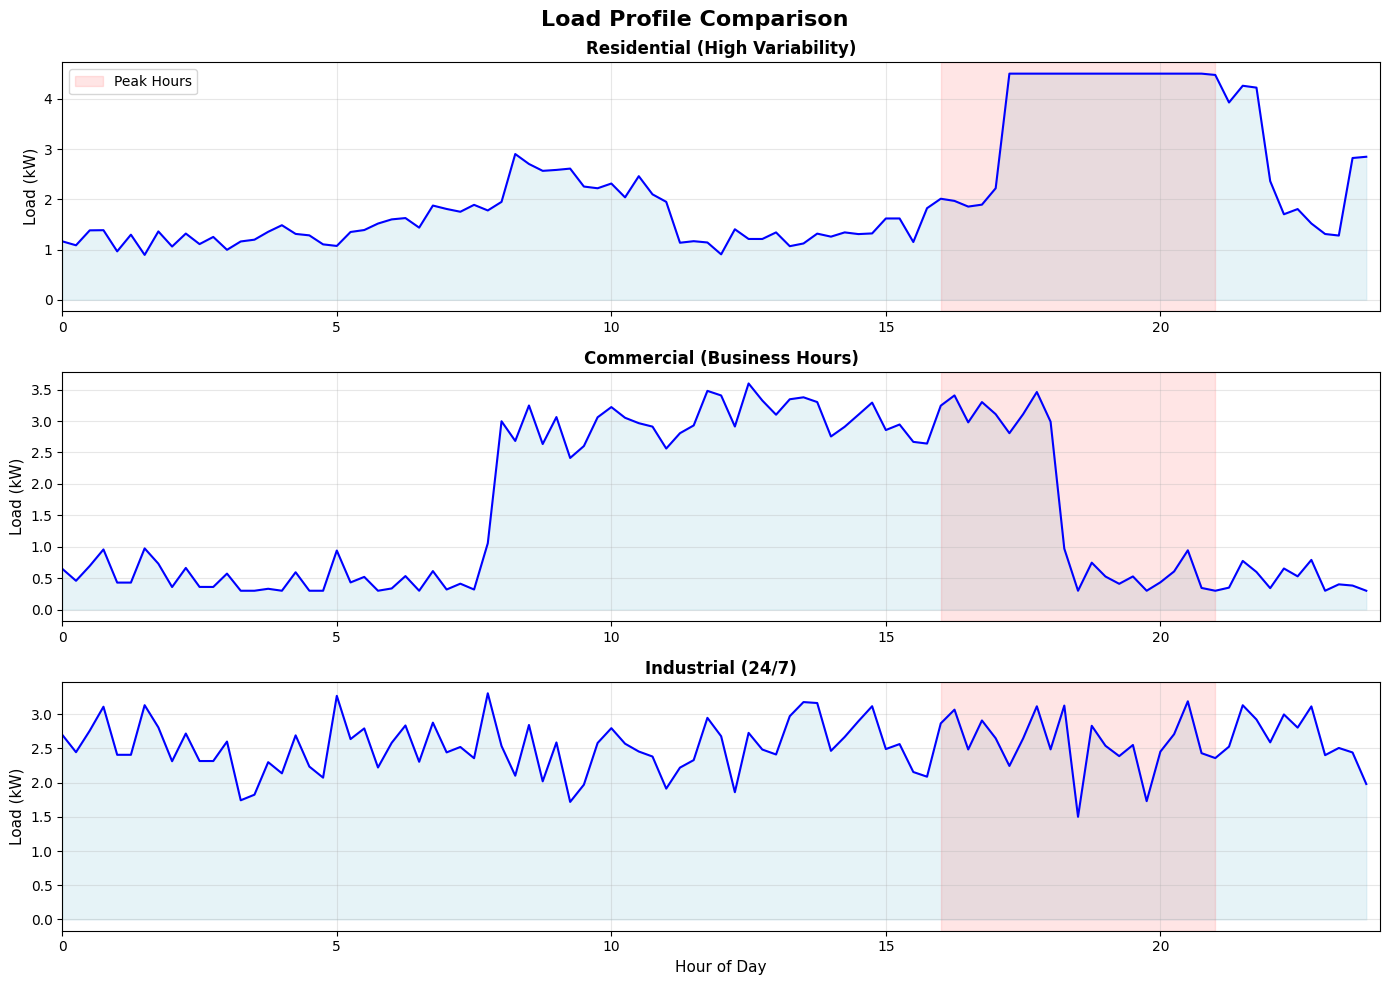

Load profile comparison saved: load_profiles_comparison.png


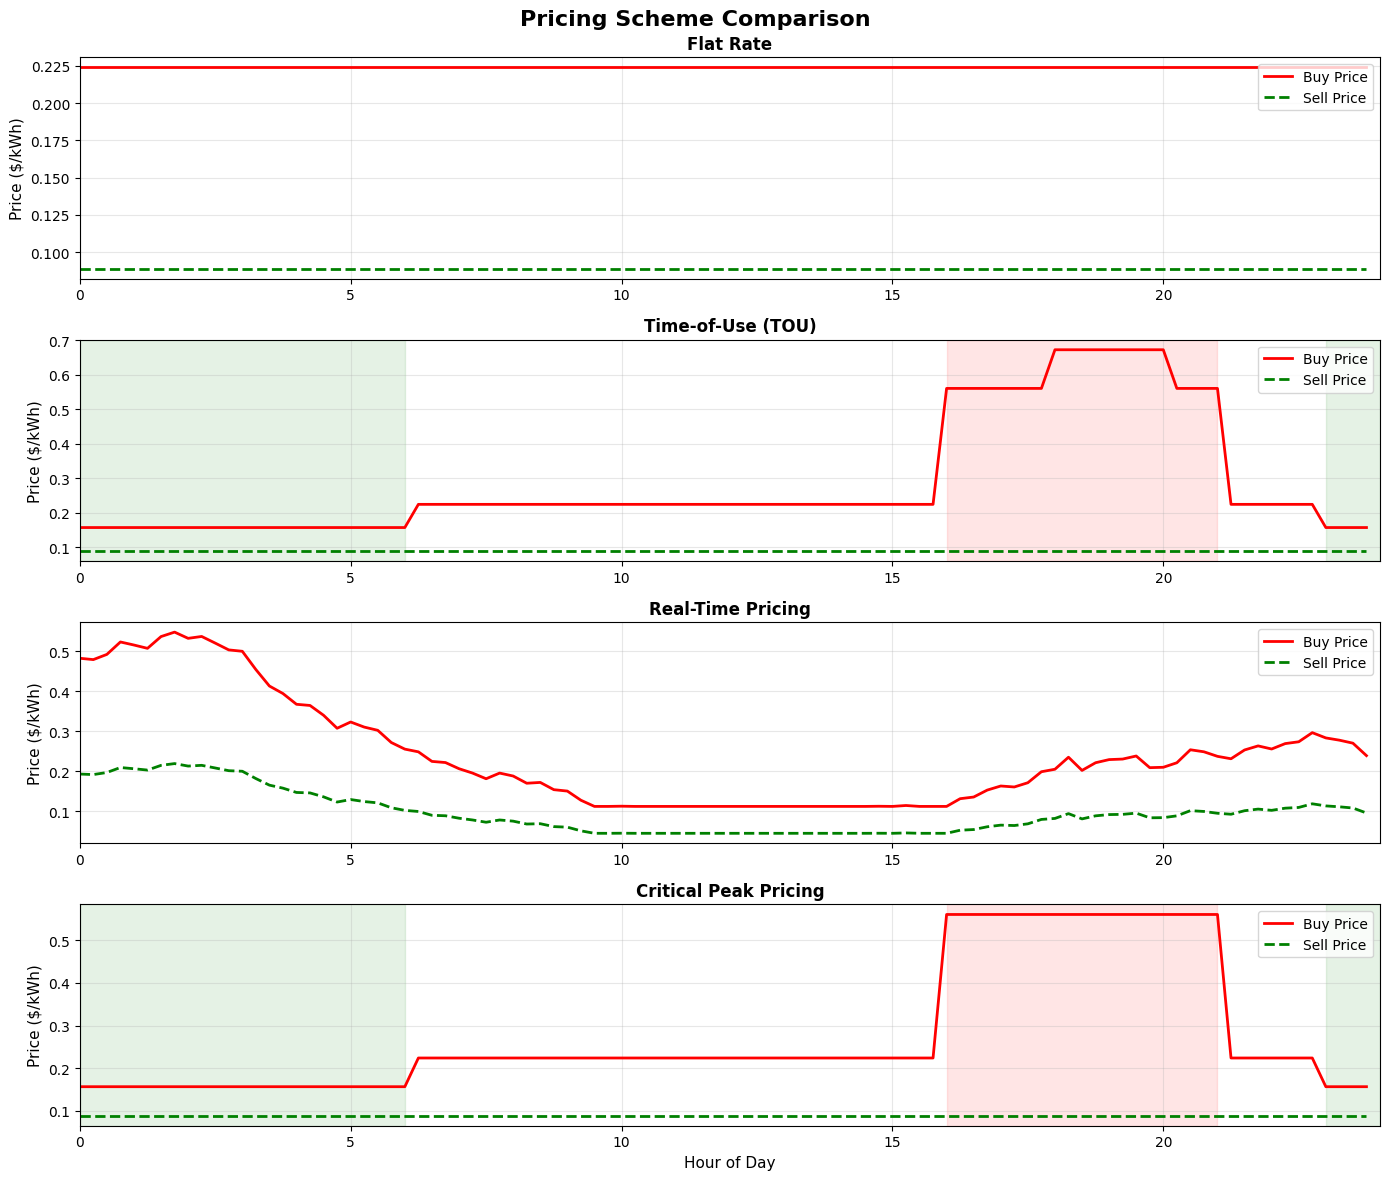

Pricing comparison saved: pricing_schemes_comparison.png


In [13]:
plot_load_comparison()
plot_pricing_comparison()

Using calibrated predictions


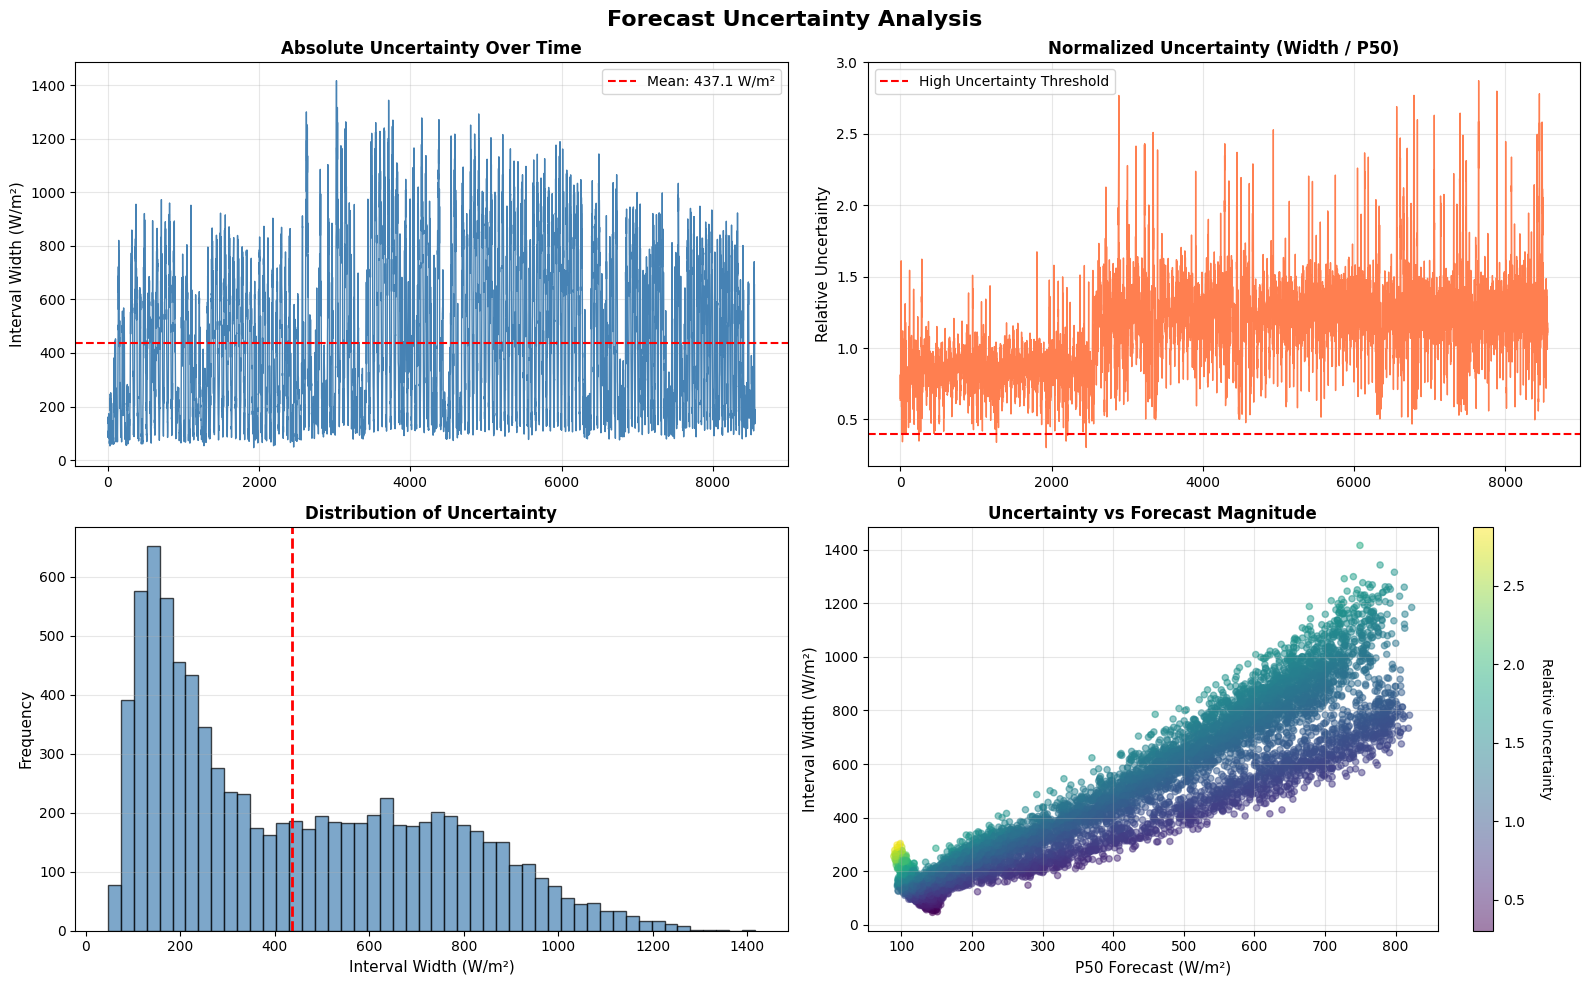

Uncertainty analysis saved


In [14]:
ghi_forecasts = load_calibrated_forecasts(
    './reports2/LSTM_mcdropout_calibrated/15_minutes/quantile_predictions_CALIBRATED_15_minutes_GHI_season_d1_P1_H10.csv'
)

analyze_forecast_uncertainty(ghi_forecasts)

COMPREHENSIVE SCENARIO ANALYSIS
Using calibrated predictions
[1/6] Baseline (Flat + Smooth)
Simple scenario - minimal advantage expected
BATTERY CONTROL STRATEGY COMPARISON

 Running Deterministic Controller (P50 only)...
 Running Risk-Aware Controller (P10/P50/P90)...
RESULTS SUMMARY

Economic Performance:
   Deterministic Total Cost:  $17.54
   Risk-Aware Total Cost:     $16.84
   Difference:                $0.70
Risk-aware saves 4.0%

Grid Interaction:
   Deterministic Import:  76.70 kWh
   Risk-Aware Import:     74.74 kWh
   Import Reduction:      1.96 kWh

Battery Health:
   Deterministic Cycles:  1.268
   Risk-Aware Cycles:     0.721
   Cycle Difference:      0.547

Comparison plot saved: battery_strategy_comparison.png


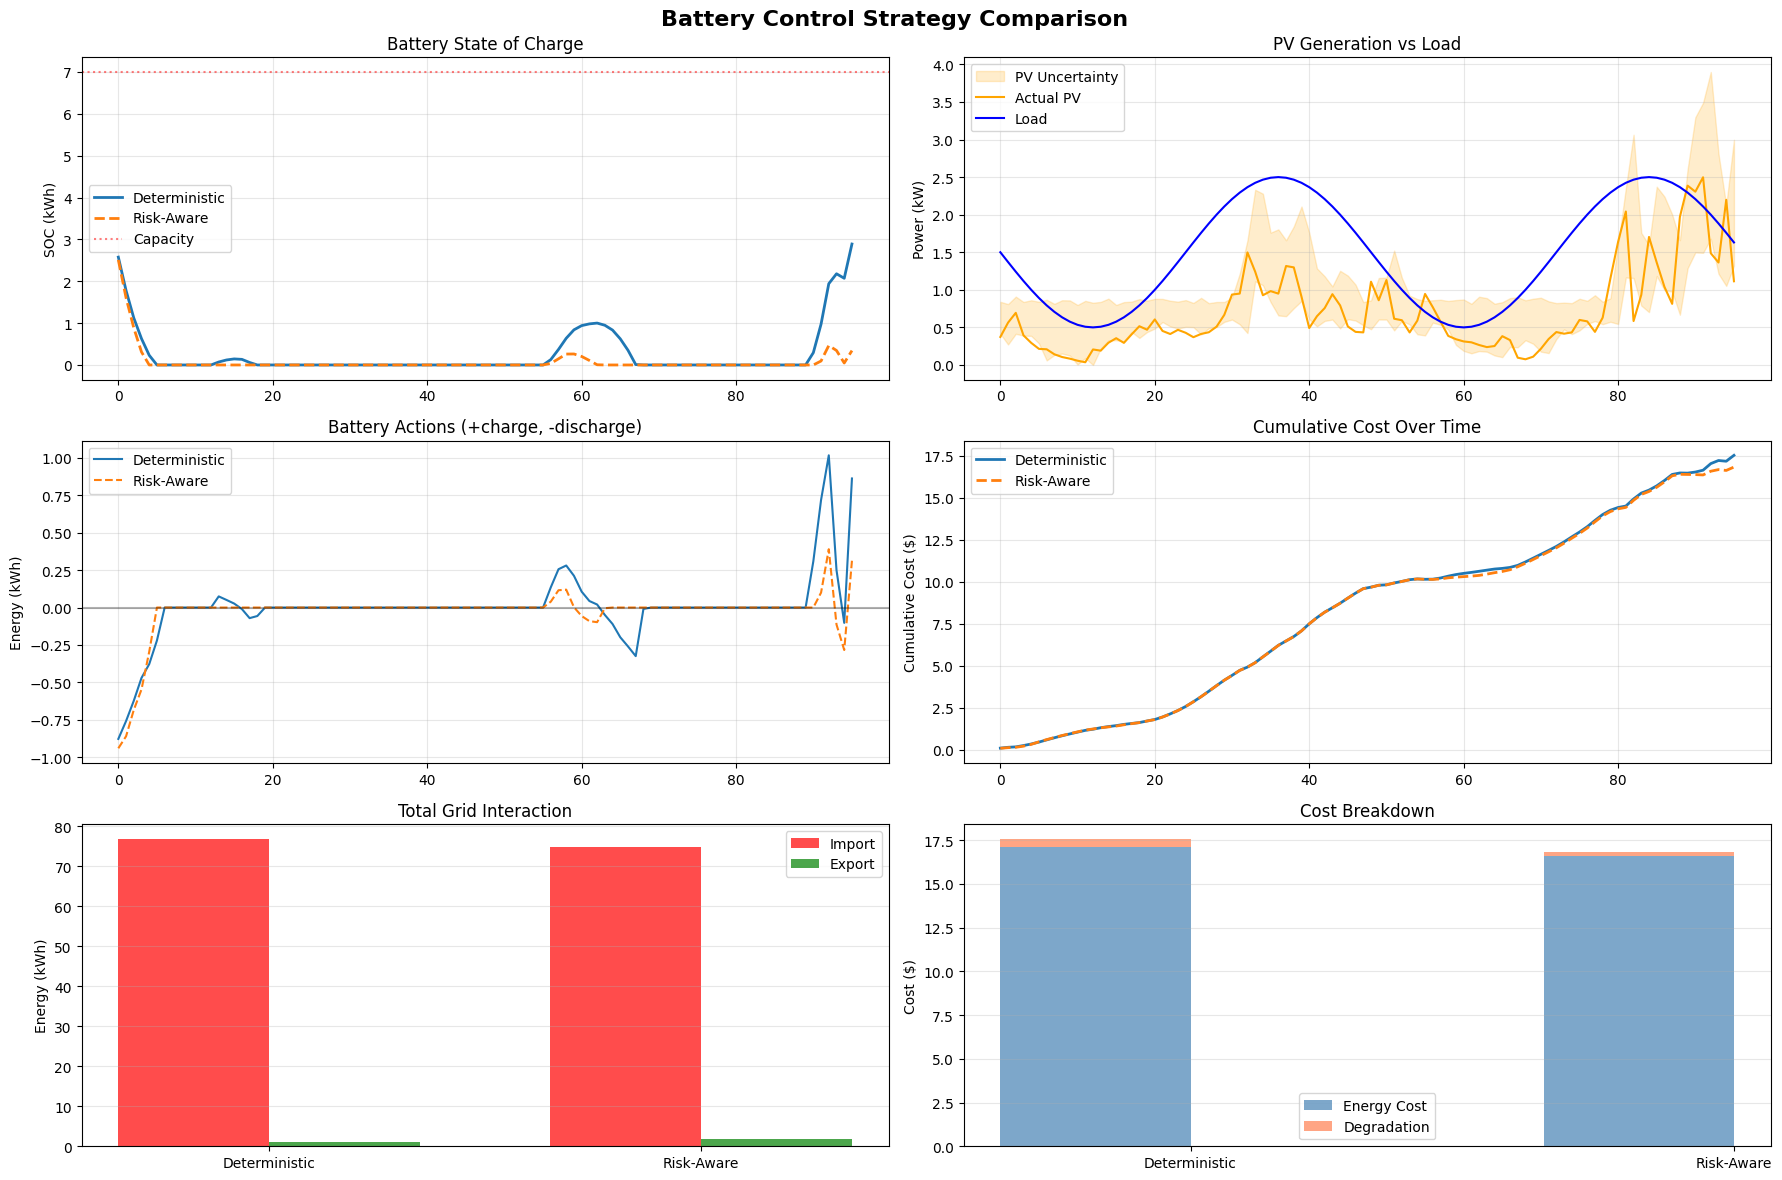

[2/6] TOU + Smooth Load
Price incentives but predictable load
BATTERY CONTROL STRATEGY COMPARISON

 Running Deterministic Controller (P50 only)...
 Running Risk-Aware Controller (P10/P50/P90)...
RESULTS SUMMARY

Economic Performance:
   Deterministic Total Cost:  $24.93
   Risk-Aware Total Cost:     $24.63
   Difference:                $0.30
Risk-aware saves 1.2%

Grid Interaction:
   Deterministic Import:  76.70 kWh
   Risk-Aware Import:     74.74 kWh
   Import Reduction:      1.96 kWh

Battery Health:
   Deterministic Cycles:  1.268
   Risk-Aware Cycles:     0.721
   Cycle Difference:      0.547

Comparison plot saved: battery_strategy_comparison.png


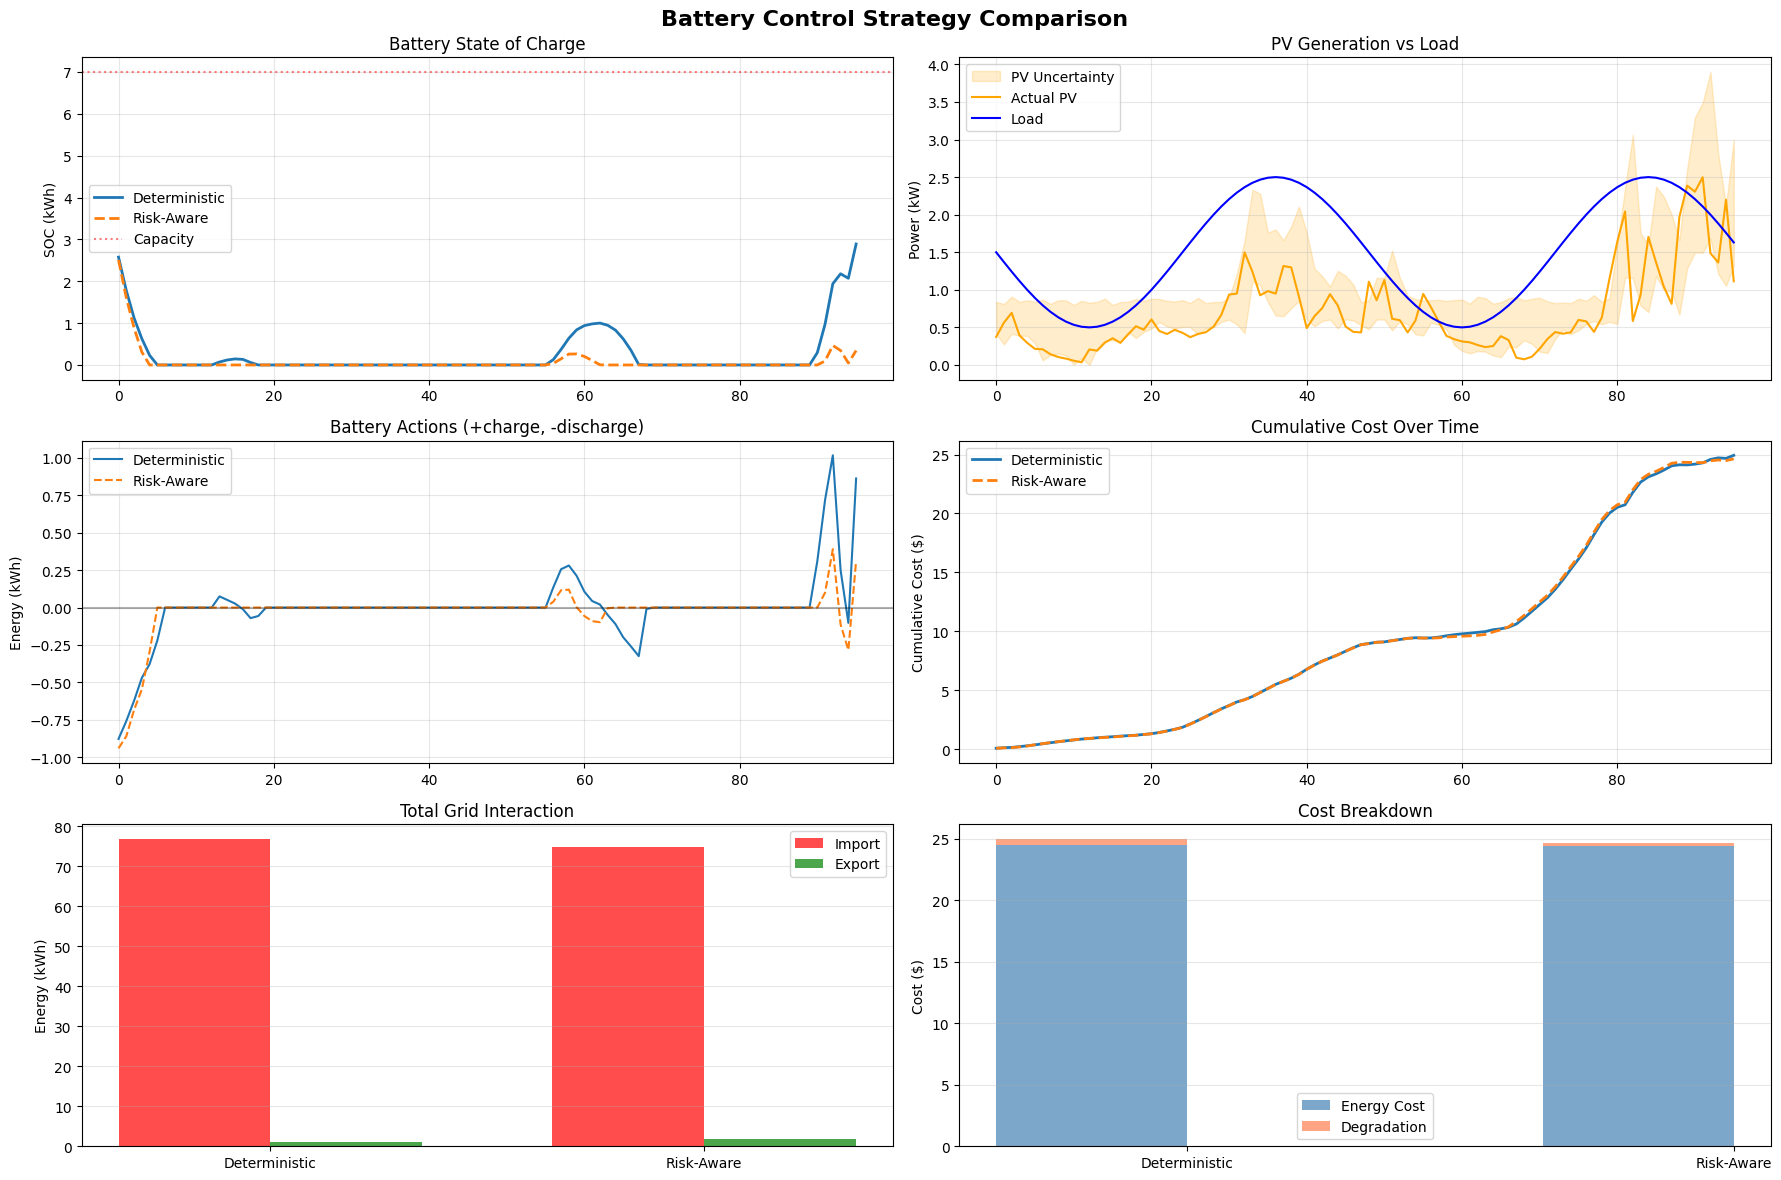

[3/6] Flat + Realistic Load
Load uncertainty but no price incentive
BATTERY CONTROL STRATEGY COMPARISON

 Running Deterministic Controller (P50 only)...
 Running Risk-Aware Controller (P10/P50/P90)...
RESULTS SUMMARY

Economic Performance:
   Deterministic Total Cost:  $36.18
   Risk-Aware Total Cost:     $35.69
   Difference:                $0.48
Risk-aware saves 1.3%

Grid Interaction:
   Deterministic Import:  159.40 kWh
   Risk-Aware Import:     157.81 kWh
   Import Reduction:      1.58 kWh

Battery Health:
   Deterministic Cycles:  1.549
   Risk-Aware Cycles:     1.391
   Cycle Difference:      0.158

Comparison plot saved: battery_strategy_comparison.png


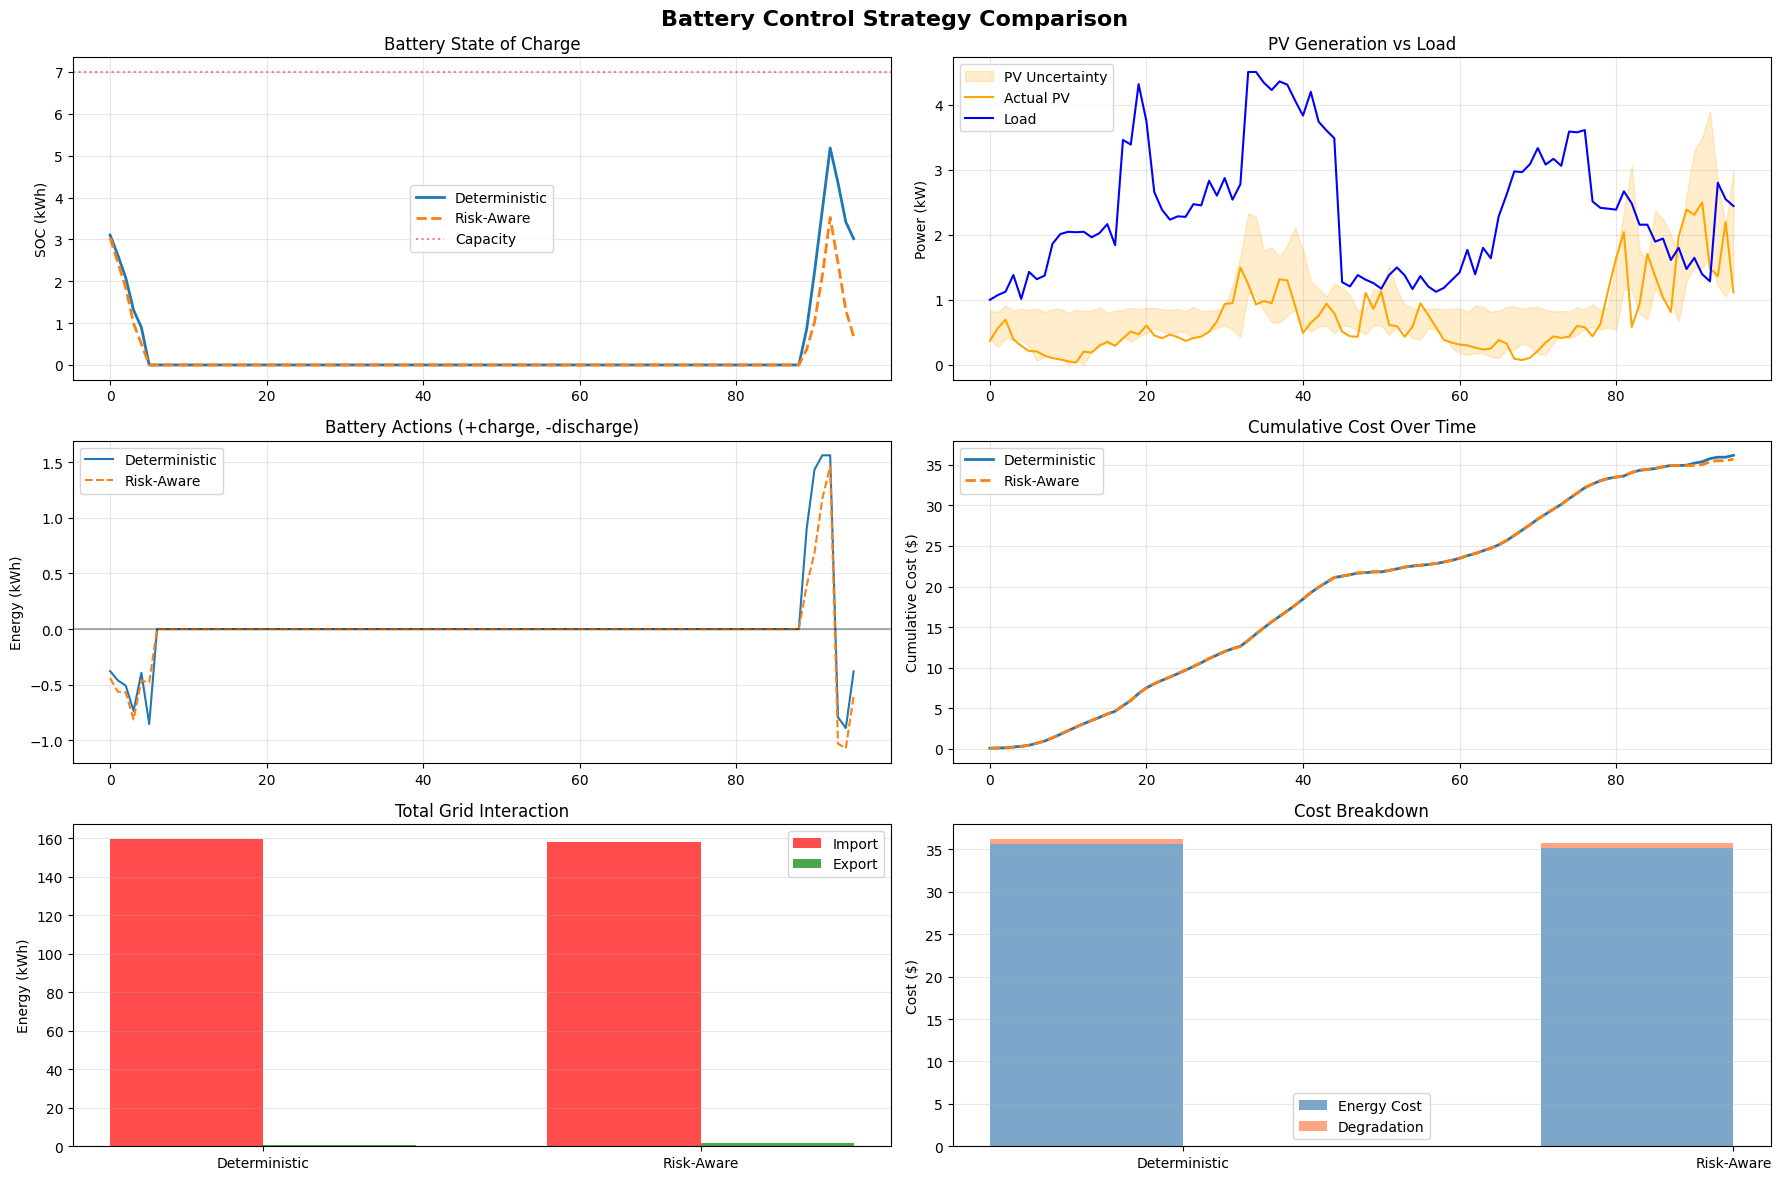

[4/6] TOU + Realistic Load
🎯 Best case for risk-aware control
BATTERY CONTROL STRATEGY COMPARISON

 Running Deterministic Controller (P50 only)...
 Running Risk-Aware Controller (P10/P50/P90)...
RESULTS SUMMARY

Economic Performance:
   Deterministic Total Cost:  $50.55
   Risk-Aware Total Cost:     $50.10
   Difference:                $0.45
Risk-aware saves 0.9%

Grid Interaction:
   Deterministic Import:  159.40 kWh
   Risk-Aware Import:     157.81 kWh
   Import Reduction:      1.58 kWh

Battery Health:
   Deterministic Cycles:  1.549
   Risk-Aware Cycles:     1.391
   Cycle Difference:      0.158

Comparison plot saved: battery_strategy_comparison.png


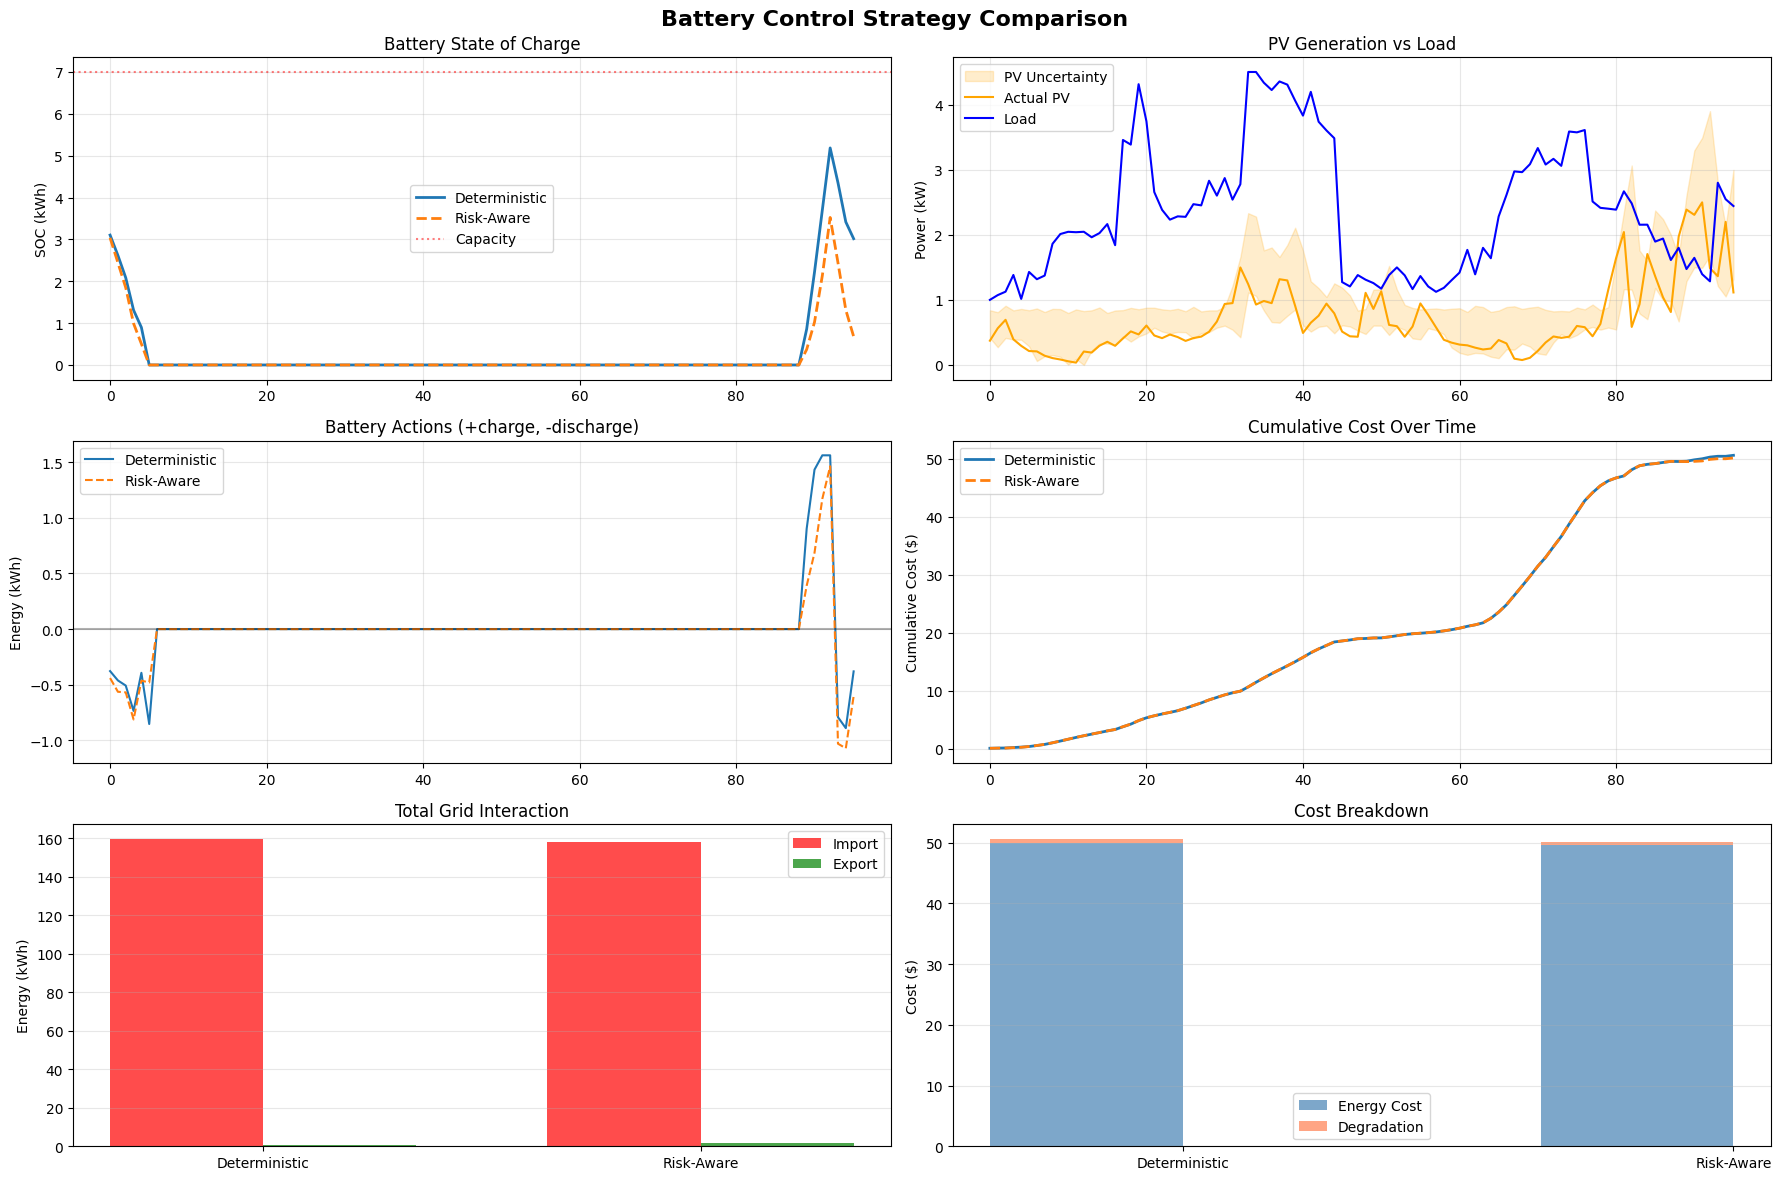

[5/6] Real-Time + Realistic
Maximum price volatility + load uncertainty
BATTERY CONTROL STRATEGY COMPARISON

 Running Deterministic Controller (P50 only)...
 Running Risk-Aware Controller (P10/P50/P90)...
RESULTS SUMMARY

Economic Performance:
   Deterministic Total Cost:  $28.74
   Risk-Aware Total Cost:     $28.18
   Difference:                $0.56
Risk-aware saves 2.0%

Grid Interaction:
   Deterministic Import:  159.40 kWh
   Risk-Aware Import:     157.81 kWh
   Import Reduction:      1.58 kWh

Battery Health:
   Deterministic Cycles:  1.549
   Risk-Aware Cycles:     1.391
   Cycle Difference:      0.158

Comparison plot saved: battery_strategy_comparison.png


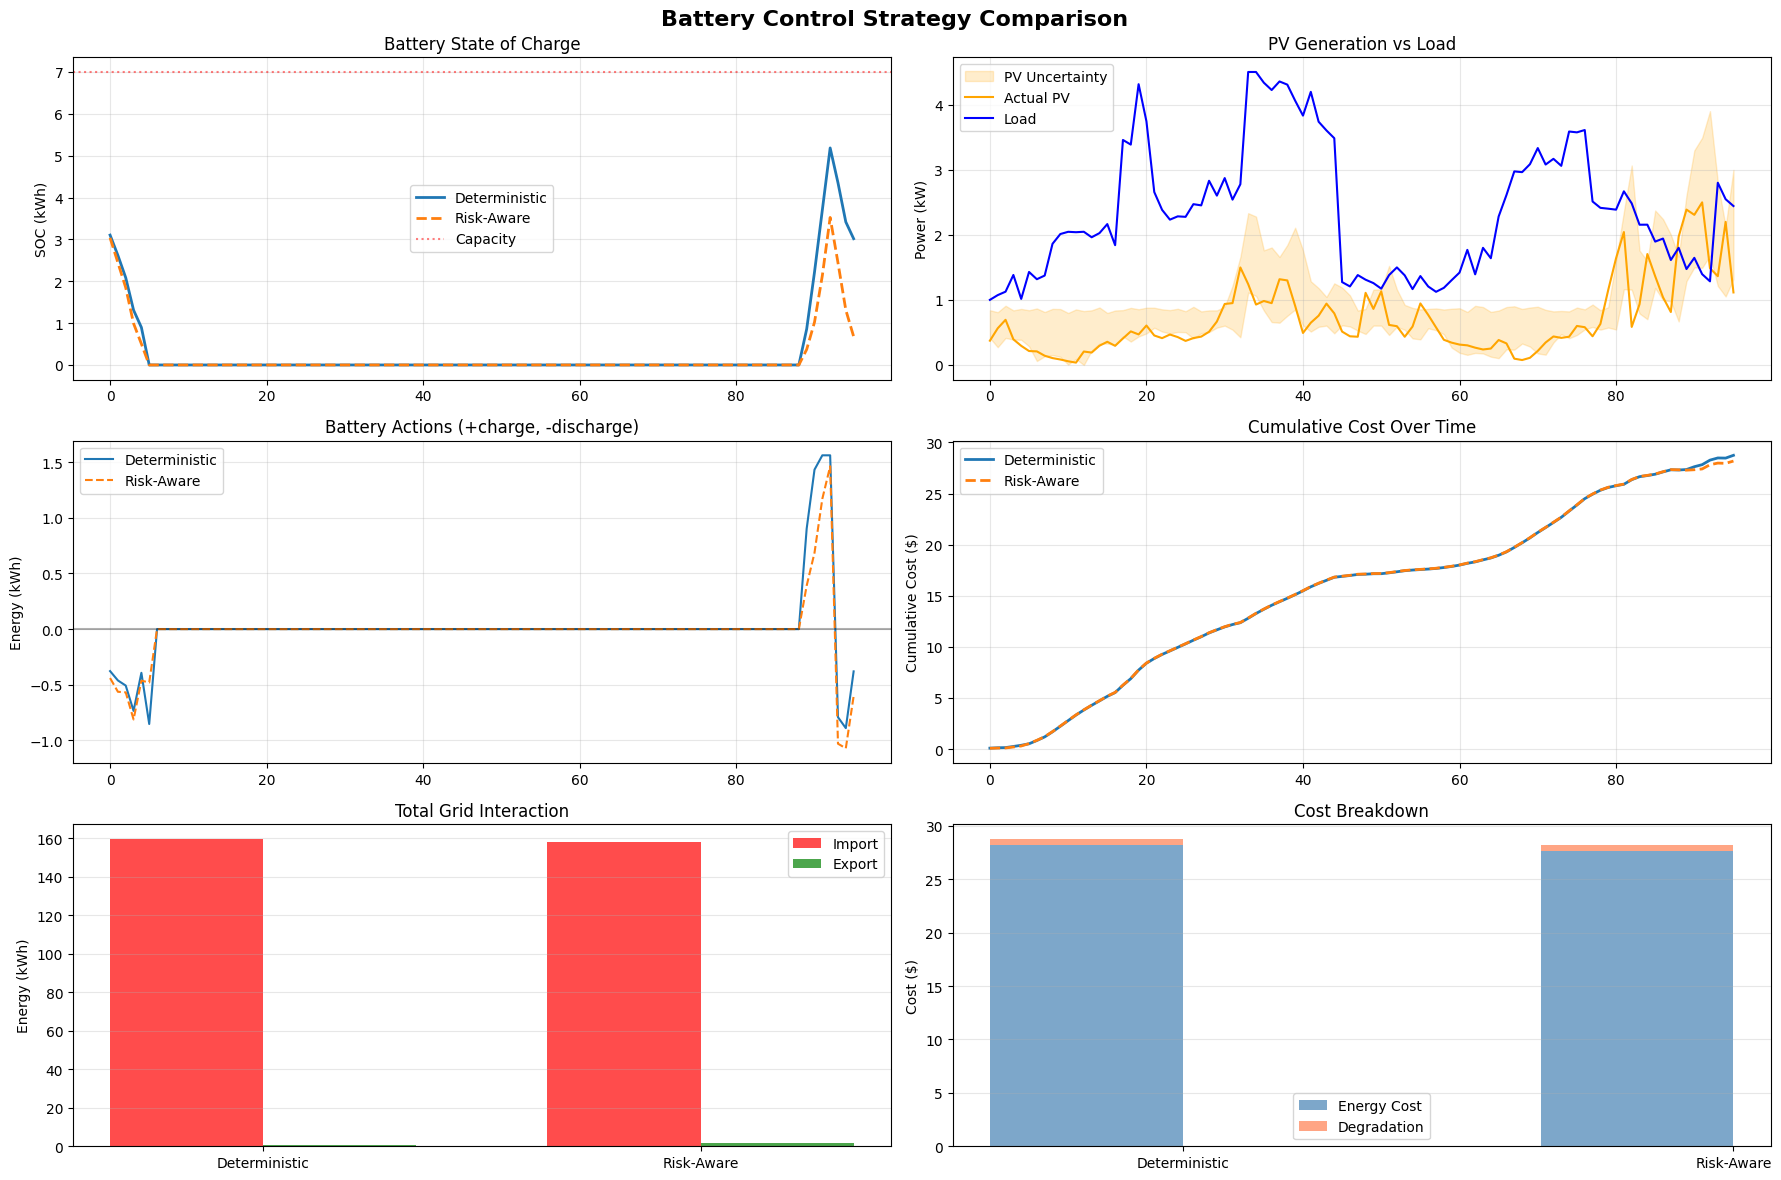

[6/6] Critical Peak + Realistic
Extreme price events + load spikes
BATTERY CONTROL STRATEGY COMPARISON

 Running Deterministic Controller (P50 only)...
 Running Risk-Aware Controller (P10/P50/P90)...
RESULTS SUMMARY

Economic Performance:
   Deterministic Total Cost:  $48.27
   Risk-Aware Total Cost:     $47.82
   Difference:                $0.45
Risk-aware saves 0.9%

Grid Interaction:
   Deterministic Import:  159.40 kWh
   Risk-Aware Import:     157.81 kWh
   Import Reduction:      1.58 kWh

Battery Health:
   Deterministic Cycles:  1.549
   Risk-Aware Cycles:     1.391
   Cycle Difference:      0.158

Comparison plot saved: battery_strategy_comparison.png


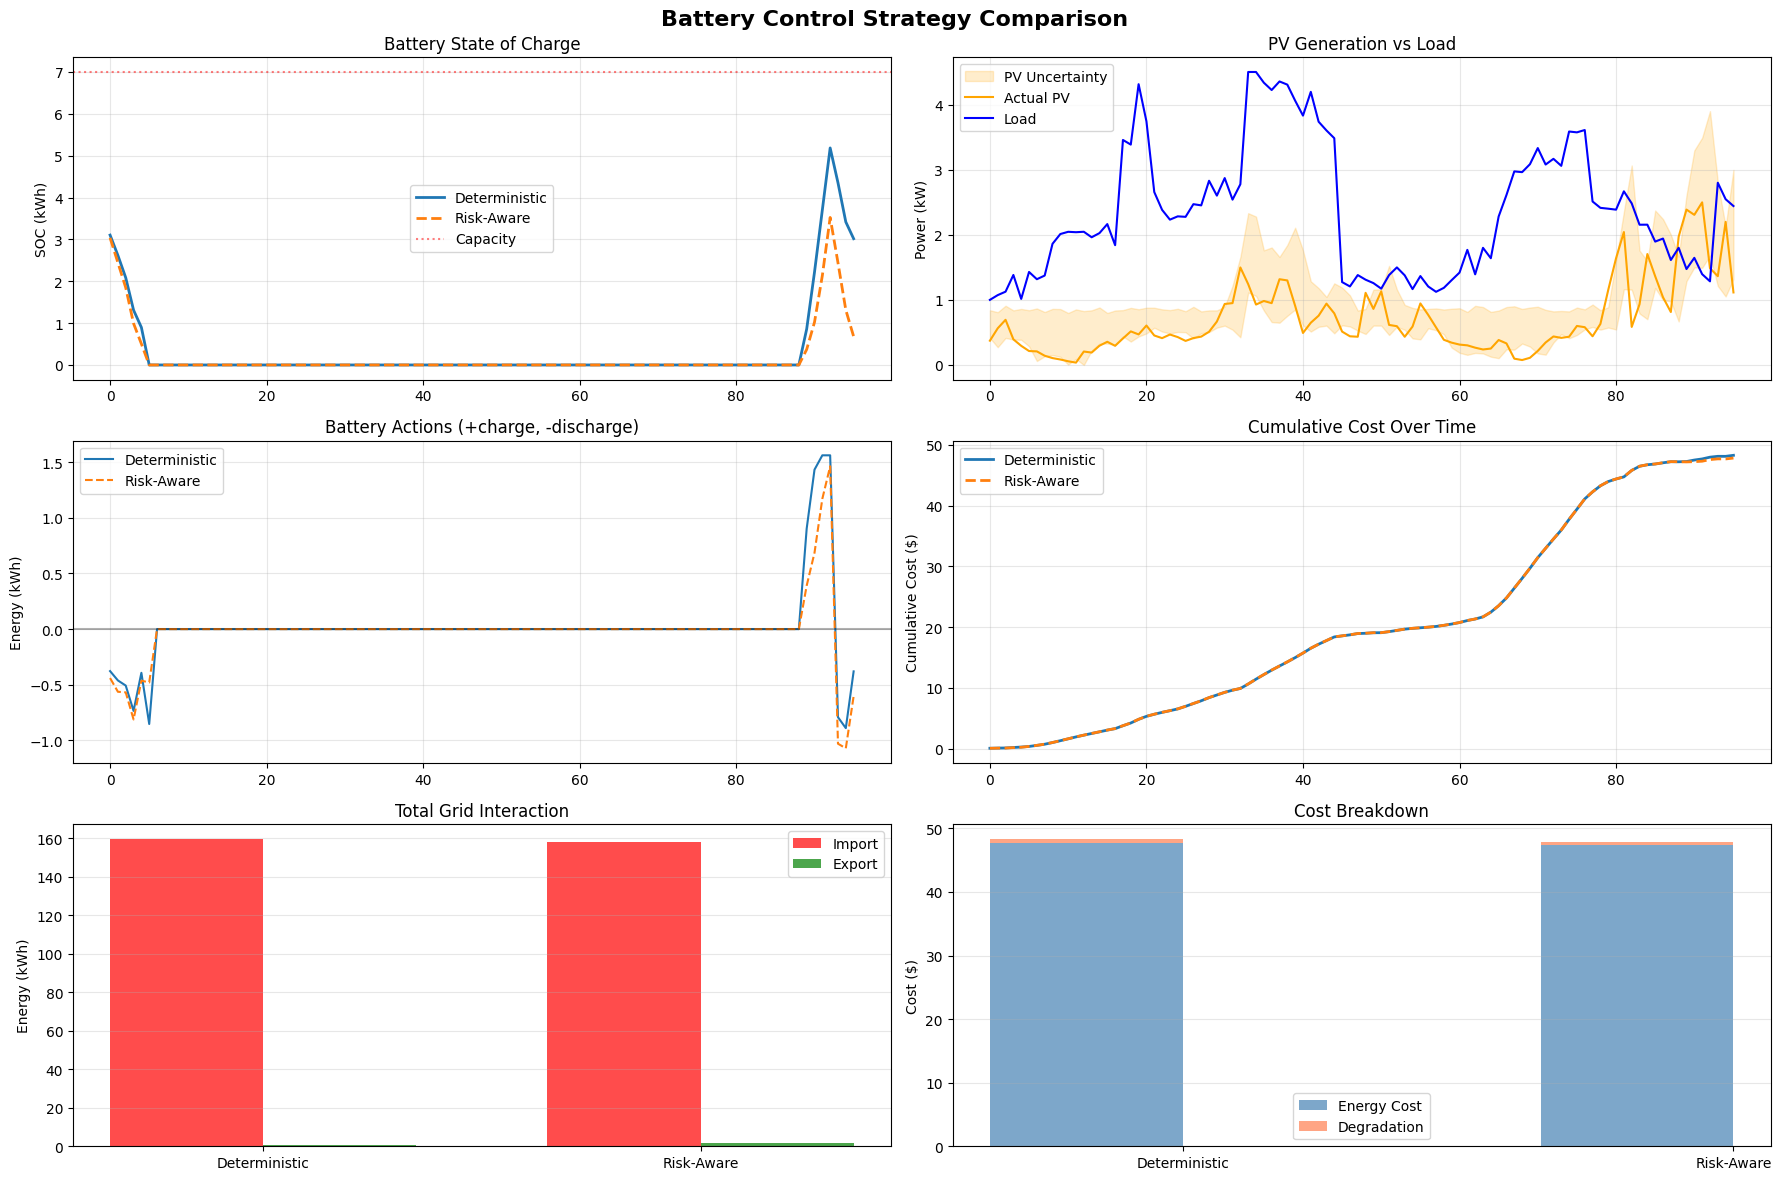

SCENARIO COMPARISON SUMMARY
                 Scenario  Savings ($)  Savings (%)
 Baseline (Flat + Smooth)     0.699595     3.988419
        TOU + Smooth Load     0.299992     1.203154
    Flat + Realistic Load     0.481713     1.331578
     TOU + Realistic Load     0.451805     0.893703
    Real-Time + Realistic     0.561812     1.954904
Critical Peak + Realistic     0.451805     0.935948

Best Scenario for Risk-Aware:
   Baseline (Flat + Smooth)
   Savings: $0.70 (3.99%)


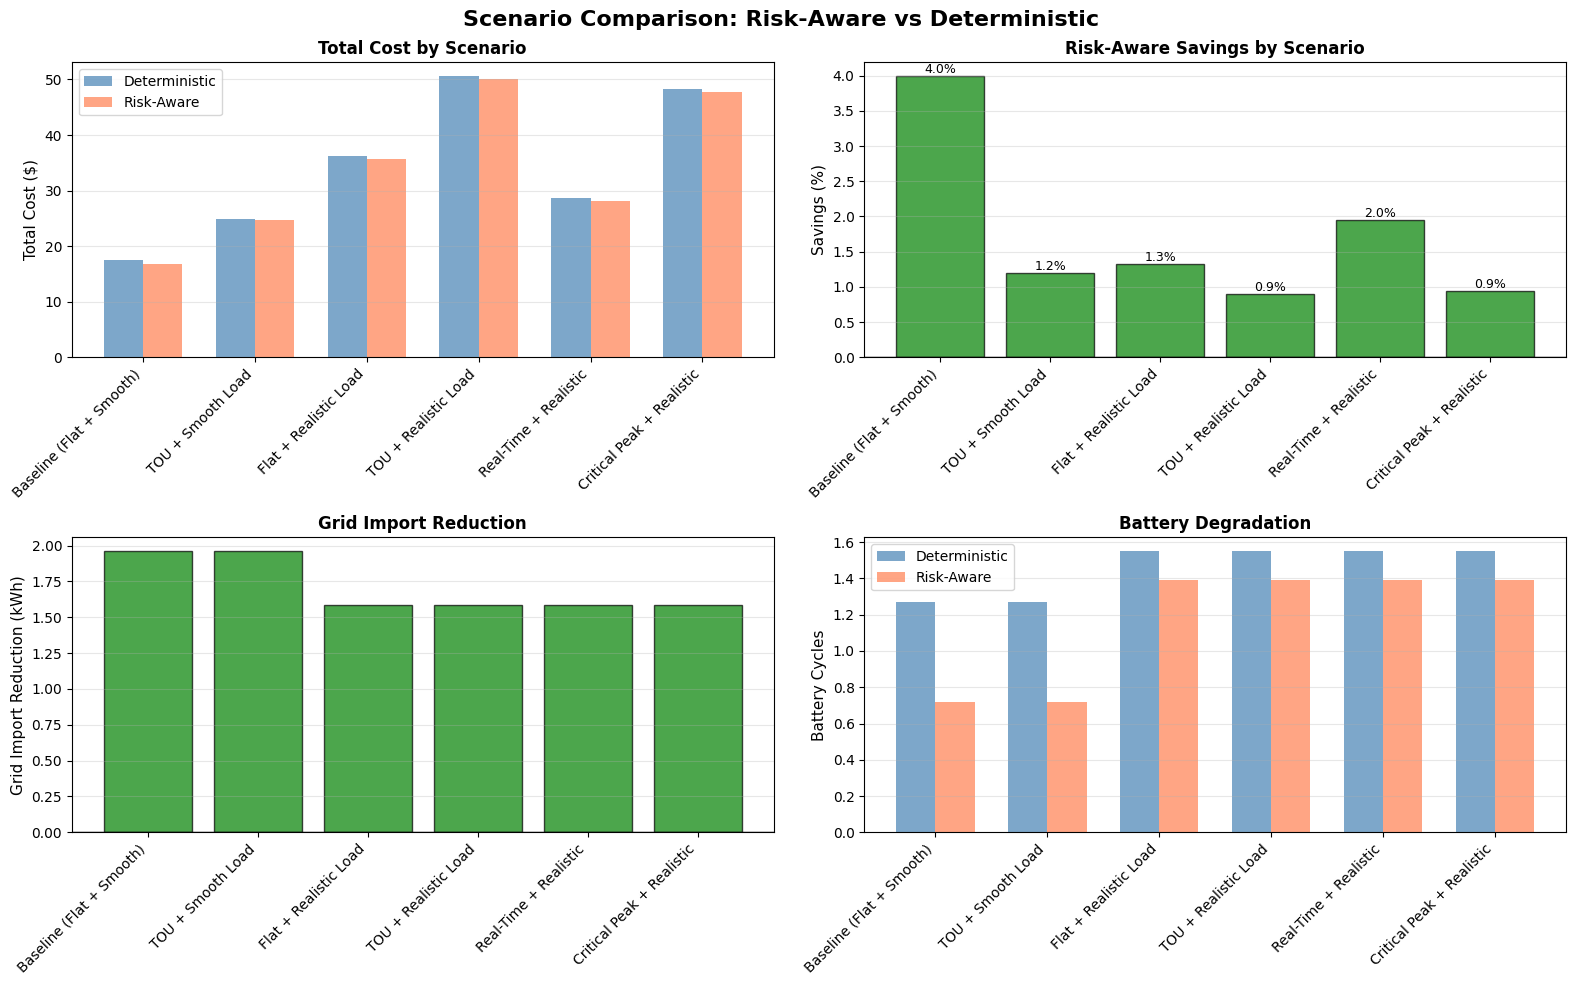

,Scenario,Load Type,Pricing,Deterministic Cost,Risk-Aware Cost,Savings ($),Savings (%),Det Cycles,Risk Cycles,Det Import (kWh),Risk Import (kWh)
0,Baseline (Flat + Smooth),smooth,flat,17.540661,16.841066,0.699595,3.988419,1.267958,0.721358,76.701885,74.742449
1,TOU + Smooth Load,smooth,time_of_use,24.933827,24.633835,0.299992,1.203154,1.267958,0.721358,76.701885,74.742449
2,Flat + Realistic Load,residential,flat,36.176099,35.694386,0.481713,1.331578,1.549091,1.391029,159.397058,157.814646
3,TOU + Realistic Load,residential,time_of_use,50.554236,50.102431,0.451805,0.893703,1.549091,1.391029,159.397058,157.814646
4,Real-Time + Realistic,residential,real_time,28.738612,28.176799,0.561812,1.954904,1.549091,1.391029,159.397058,157.814646
5,Critical Peak + Realistic,residential,critical_peak,48.272397,47.820592,0.451805,0.935948,1.549091,1.391029,159.397058,157.814646


In [15]:
summary_df = run_scenario_analysis(
    calibrated_csv_path='./reports2/LSTM_mcdropout_calibrated/15_minutes/quantile_predictions_CALIBRATED_15_minutes_GHI_season_d1_P1_H10.csv',
    output_dir='./phase2_scenarios'
)

summary_df

Using calibrated predictions

Found 6 high-uncertainty periods
   Total timesteps: 2377
   Using longest segment: timesteps 250 to 1272 (1022 steps)

Filtered dataset size: 1022 timesteps (255.5 hours)
TESTING ON HIGH-UNCERTAINTY DAYS ONLY
BATTERY CONTROL STRATEGY COMPARISON

 Running Deterministic Controller (P50 only)...
 Running Risk-Aware Controller (P10/P50/P90)...
RESULTS SUMMARY

Economic Performance:
   Deterministic Total Cost:  $26.69
   Risk-Aware Total Cost:     $25.93
   Difference:                $0.75
Risk-aware saves 2.8%

Grid Interaction:
   Deterministic Import:  111.45 kWh
   Risk-Aware Import:     111.27 kWh
   Import Reduction:      0.18 kWh

Battery Health:
   Deterministic Cycles:  6.225
   Risk-Aware Cycles:     4.821
   Cycle Difference:      1.404

Comparison plot saved: battery_strategy_comparison.png


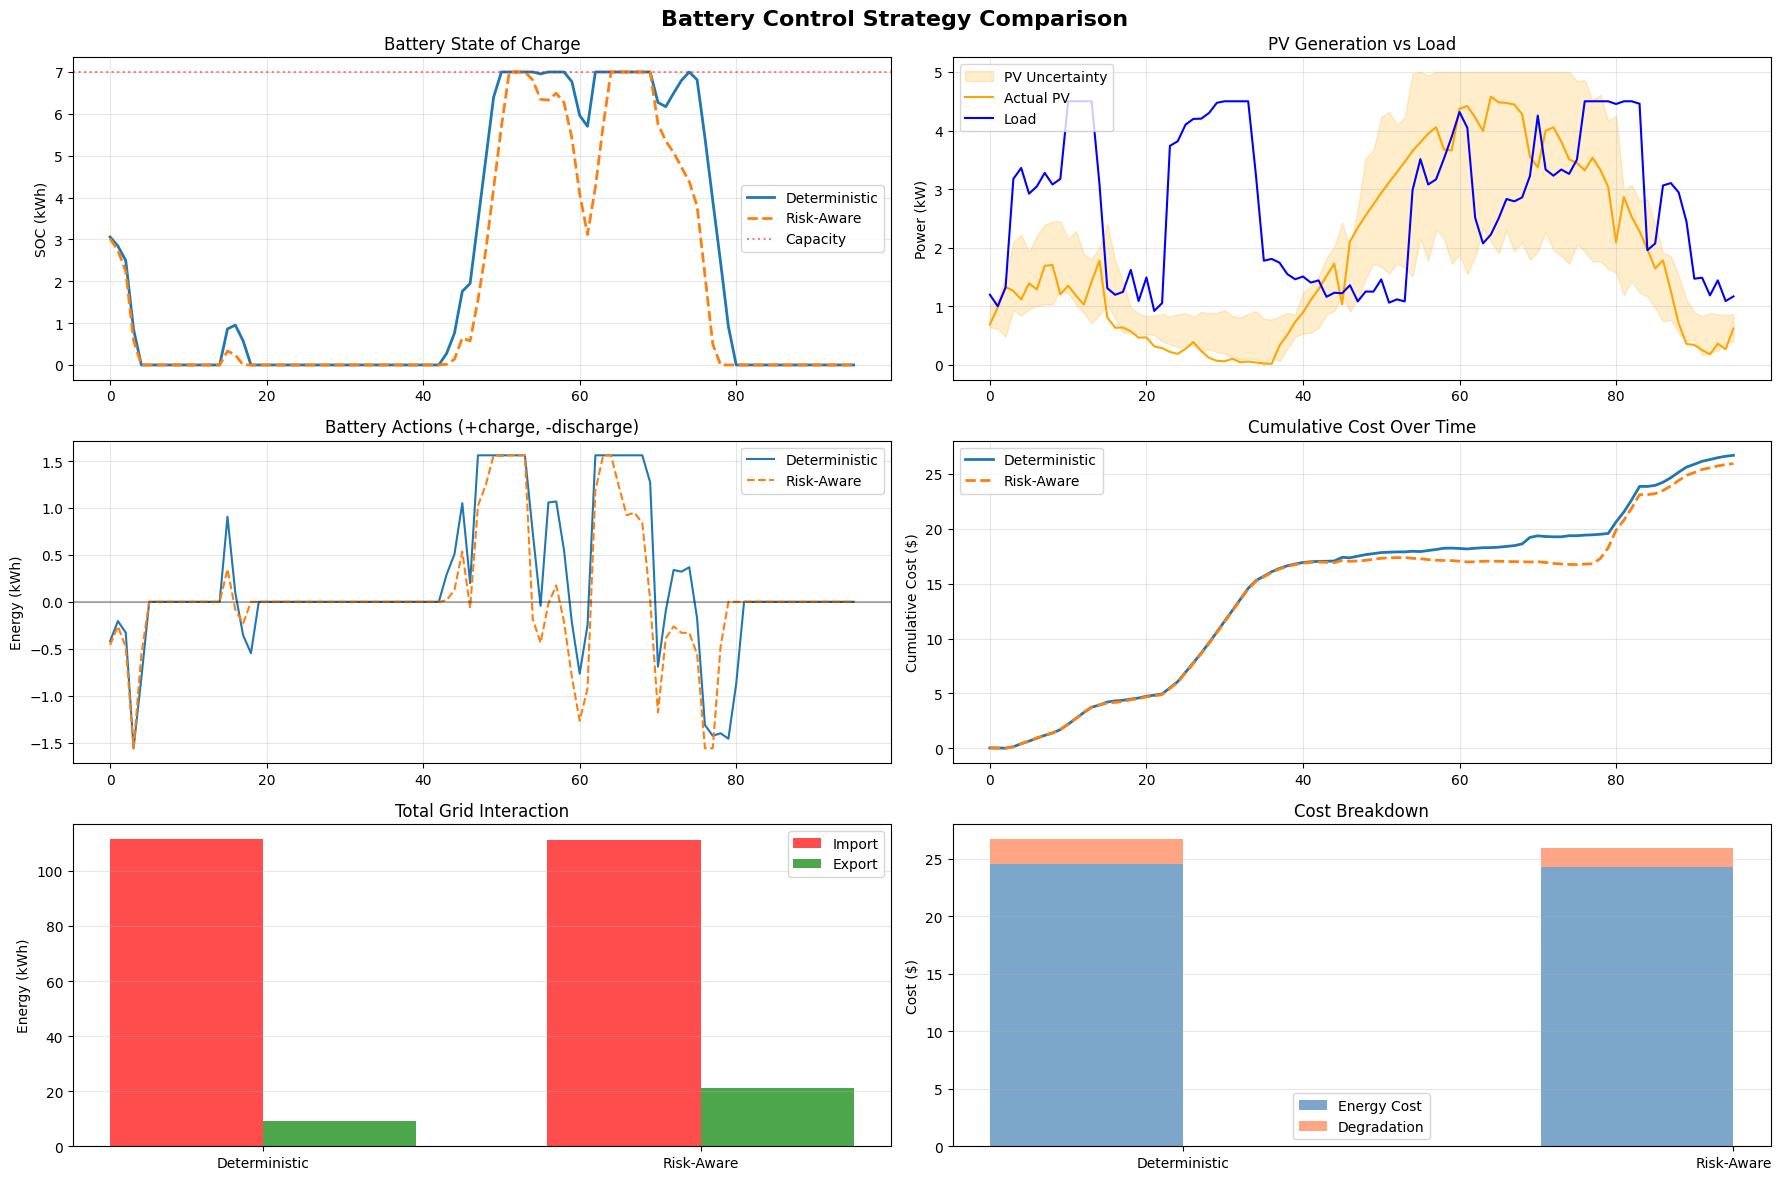

In [16]:
ghi_forecasts = load_calibrated_forecasts(
    './reports2/LSTM_mcdropout_calibrated/15_minutes/quantile_predictions_CALIBRATED_15_minutes_GHI_season_d1_P1_H10.csv'
)
pv_forecasts = prepare_battery_inputs(ghi_forecasts)

filtered_ghi, filtered_pv = filter_high_uncertainty_days(
    ghi_forecasts, pv_forecasts, 
    uncertainty_threshold=0.4 
)

n_filtered = len(filtered_pv['pv_actual'])
print(f"\nFiltered dataset size: {n_filtered} timesteps ({n_filtered * 0.25:.1f} hours)")

load_filtered = create_realistic_load_profile(n_filtered, 'residential')
buy_filtered, sell_filtered = create_pricing_scheme(n_filtered, 'time_of_use')


print("TESTING ON HIGH-UNCERTAINTY DAYS ONLY")

comparison_filtered = compare_strategies(
    filtered_pv, filtered_pv['pv_actual'],
    load_filtered, buy_filtered, sell_filtered
)